In [637]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
import os
import scipy.stats as scs
import os.path
from os import path
from sklearn.linear_model import LinearRegression
import mdtraj as md
import sys
sys.path.append('/storage1/francesco/PROJECTS/BLOCKING/WIP/')
from main import BlockAnalysis
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import string
from localcider.sequenceParameters import SequenceParameters

In [2]:
def kde(a, w=None, kappa=0, l=0):
    if type(w) == 'NoneType':
        w = np.full(len(a), 1)
    min_ = np.min(a)
    max_ = np.max(a)
    x = np.linspace( min_, max_, num = 50 )
    d = scs.gaussian_kde( a, bw_method = "silverman", weights = w ).evaluate(x)
    u = 1./np.average(1./a, weights = w)
    return x,d,u

def kde_rg(a, w=None):
    if type(w) == 'NoneType':
        w = np.full(len(a), 1)
    min_ = np.min(a)
    max_ = np.max(a)
    x = np.linspace( min_, max_, num = 50 )
    d = scs.gaussian_kde( a, bw_method = "silverman", weights = w ).evaluate(x)
    u = np.average(a, weights = w)
    return x,d,u

def autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

def autoblock(x):
    blocks = BlockAnalysis(x)
    stat = blocks.stat
    tc, err = blocks.err()
    plt.errorbar(stat[...,0]/200,stat[...,1],stat[...,2],fmt='ro',ms=2)
    plt.scatter(tc/200,err,c='k',zorder=300,s=5)
    plt.ylabel('SEM [nm]')
    plt.xlabel('Block length [ns]')
    plt.show()
    return blocks.x.mean(), err

def fix_topology(t,seq):
    cgtop = md.Topology()
    cgchain = cgtop.add_chain()
    for res in seq:
        cgres = cgtop.add_residue(res, cgchain)
        cgtop.add_atom('CA', element=md.element.carbon, residue=cgres)
    traj = md.Trajectory(t.xyz, cgtop, t.time, t.unitcell_lengths, t.unitcell_angles)
    traj = traj.superpose(traj, frame=0)
    return traj

In [619]:
mpl.style.use('default')
prop_cycle = plt.rcParams['axes.prop_cycle']
c = prop_cycle.by_key()['color']

In [4]:
name = ('Hst5', 'Sic1', 'aSyn', 'Tau', 'GHR-ICD', 'NHE6cmdd', 'ANAC046', 'RS', 'DSS1', 'ProTa')

### Building dataset

In [5]:
dataset = {}
dataset['name'] = name
dataset['Rh'] = (1.275, 2.15, 2.79, 5.4, 5.08, 2.67, 3.04, 1.19, 1.70, 2.89)
dataset['Rh_err'] = (0.024, 0.11, 0.03, 0.2, 0.02, 0.02, 0.01, 0.01, 0.06, 0.08)
dataset['sequence'] = [open('/storage1/francesco/PROJECTS/ENSEMBLES/{:s}/{:s}.fasta'.format(x,x)).readlines()[1].strip() for x in dataset['name']]
dataset['length'] = [len(x) for x in dataset['sequence']]

dataset = pd.DataFrame(dataset).sort_values('length').set_index('name')
dataset.to_csv('/storage1/francesco/PROJECTS/EXP_DATA/Rh.csv')

In [6]:
dataset

Rh  Rh_err                                           sequence  \
name                                                                         
Hst5      1.275   0.024                           DSHAKRHHGYKRKFHEKHHSHRGY   
RS        1.190   0.010                           GAMGPSYGRSRSRSRSRSRSRSRS   
DSS1      1.700   0.060  MSRAALPSLENLEDDDEFEDFATENWPMKDTELDTGDDTLWENNWD...   
Sic1      2.150   0.110  MTPSTPPRSRGTRYLAQPSGNTSSSALMQGQKTPQKPSQNLVPVTP...   
ProTa     2.890   0.080  GPSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNANEENGE...   
NHE6cmdd  2.670   0.020  GPPLTTTLPACCGPIARCLTSPQAYENQEQLKDDDSDLILNDGDIS...   
aSyn      2.790   0.030  MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...   
ANAC046   3.040   0.010  NAPSTTITTTKQLSRIDSLDNIDHLLDFSSLPPLIDPGFLGQPGPS...   
GHR-ICD   5.080   0.020  SKQQRIKMLILPPVPVPKIKGIDPDLLKEGKLEEVNTILAIHDSYK...   
Tau       5.400   0.200  MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKES...   

          length  
name              
Hst5          24  
RS            24  
DSS1          71  
Sic1          90  
ProTa        111  
NHE6cmdd     116  
aSyn         140  
ANAC046      167  
GHR-ICD      351  
Tau          441

In [139]:
avg_rel_err = np.average([dataset.Rh_err[p] / dataset.Rh[p] for p in dataset.index])

In [140]:
avg_rel_err

0.020387230347211592

In [141]:
dataset['Rh_rel_err'] = [e*avg_rel_err for e in dataset.Rh]

In [868]:
names_form = ['Hst5', 'RS', 'Dss1', 'Sic1', r'ProT$\alpha$', 'NHE6cmdd', r'$\alpha$Syn', 'ANAC046', 'GHR-ICD', 'Tau']

### Sequence features

In [628]:
scd = []
ncpr = []
frac_pro = []
frac_plus = []
frac_minus = []
for s in dataset.sequence:
    SeqObj = SequenceParameters(s)
    scd.append( SeqObj.get_SCD() )
    ncpr.append( SeqObj.get_NCPR() )
    frac_pro.append( s.count('P')/len(s)*100 )
    frac_plus.append( SeqObj.get_fraction_positive()*100 )
    frac_minus.append( SeqObj.get_fraction_negative()*100 )

In [947]:
d = {'SCD': np.around(np.array(scd),1), 'NCPR': np.around(np.array(ncpr),1), 'Fraction positive': np.around(np.array(frac_plus),1), 'Fraction negative': np.around(np.array(frac_minus),1), 'Fraction proline': np.around(np.array(frac_pro),1)}
d = pd.DataFrame(data=d, index=dataset.index)
d.to_latex('seq_feat.tex')

In [946]:
d

SCD  NCPR  Fraction positive  Fraction negative  Fraction proline
name                                                                        
Hst5       0.8   0.2               29.2                8.3               0.0
RS         2.7   0.3               33.3                0.0               4.2
DSS1       6.9  -0.3                7.0               32.4               2.8
Sic1       3.5   0.1               12.2                0.0              16.7
ProTa     39.5  -0.4                9.0               47.7               1.8
NHE6cmdd   2.6  -0.1                6.9               17.2               9.5
aSyn      -1.2  -0.1               10.7               17.1               3.6
ANAC046    2.2  -0.1                4.2               10.8               8.4
GHR-ICD   10.5  -0.1                7.4               16.0               8.5
Tau       -8.1   0.0               13.2               12.7               9.8

### Simulation analyses
#### FF: TSCL-M1; 1 us

In [92]:
residues = pd.read_csv('/storage1/francesco/PROJECTS/IDP_EVO/MAIN/residues.csv').set_index('one', drop=False)

In [355]:
# Load trajectories
traj = {}
folder = '/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/'
for p in dataset.index:
    traj[p] = md.load(folder+p+'/traj.dcd', top=folder+p+'/top.pdb')

In [659]:
# Compute Rg
rg_ca = {}
for p in dataset.index:
    rg_ca[p] = md.compute_rg(traj[p])

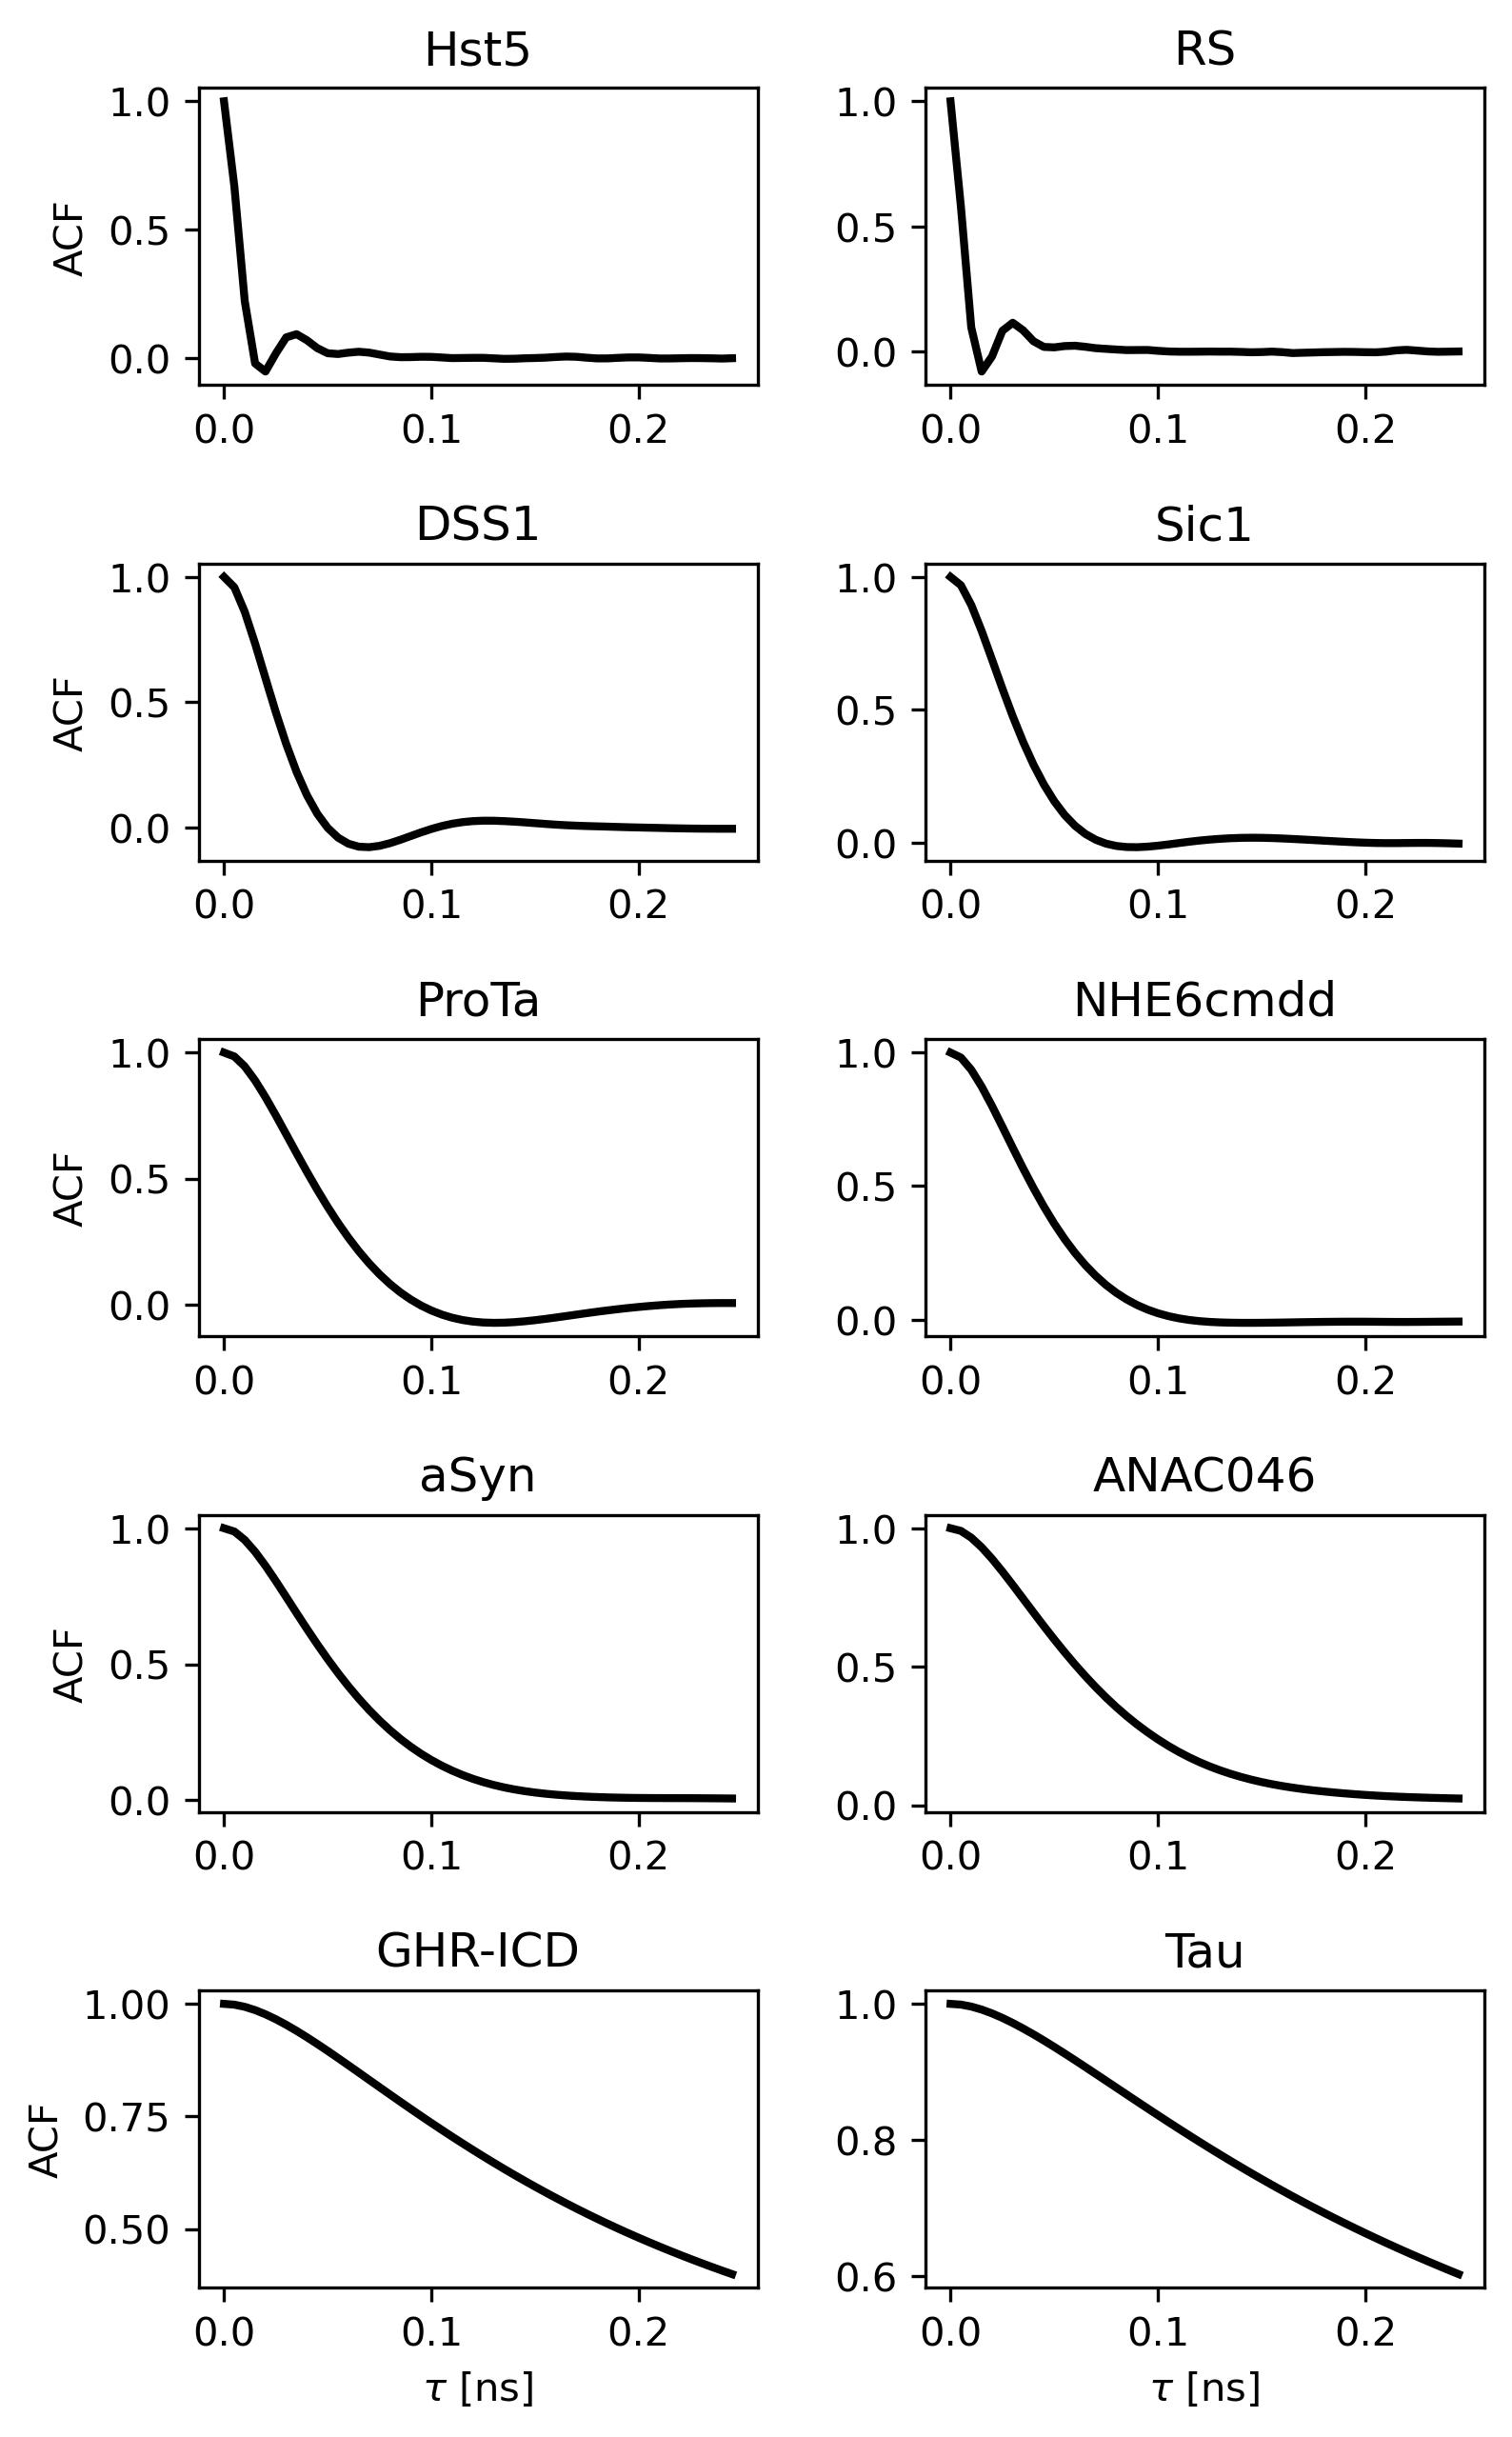

In [963]:
# Calculate autocorrelation function
fig, axs = plt.subplots(5, 2, figsize=(5,7), dpi=300, facecolor='w')
for p, ax in zip(dataset.index, axs.flatten()):
    ax.plot((np.arange(len(v))/200)[:50], autocorrelation(rg_ca[p])[:50],c='k',linewidth=2)
    ax.set_title(p)

axs.flatten()[8].set_xlabel(r'$\tau$ [ns]')
axs.flatten()[9].set_xlabel(r'$\tau$ [ns]')
for i in range(5):
    axs[i,0].set_ylabel('ACF')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.0, 
                    top=1.2, 
                    wspace=0.3, 
                    hspace=0.6)

plt.savefig('acf.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

Hst5


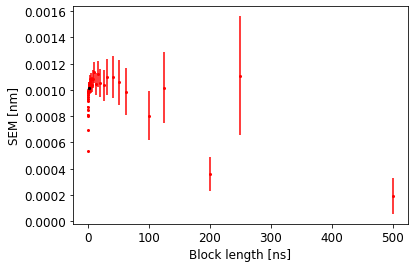

Sic1


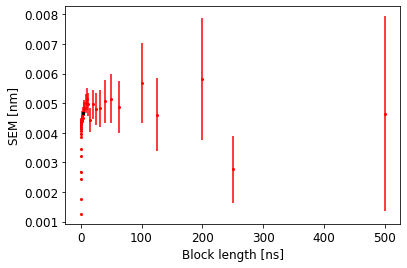

aSyn


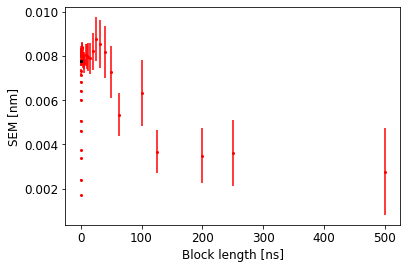

Tau


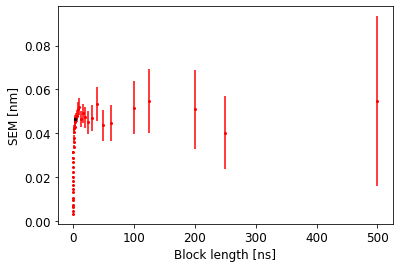

GHR-ICD


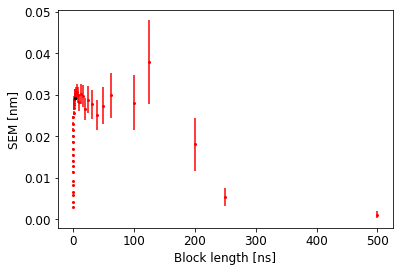

NHE6cmdd


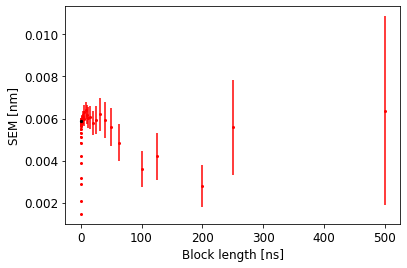

ANAC046


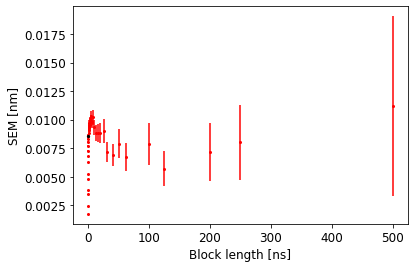

RS


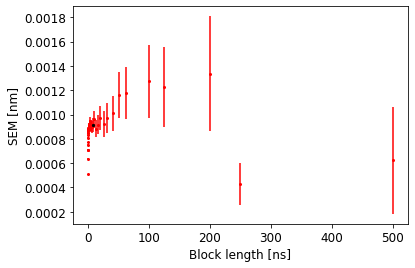

DSS1


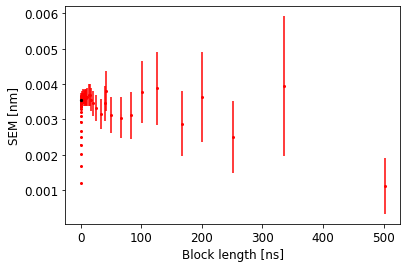

ProTa


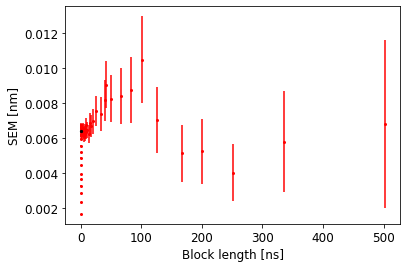

In [378]:
for k,v in rg_ca.items():
    print(k)
    autoblock(v)

In [247]:
asph = {}
acyl = {}
rel_shape_ani = {}
for p,t in traj.items():
    asph[p] = md.asphericity(t)
    acyl[p] = md.acylindricity(t)
    rel_shape_ani[p] = md.relative_shape_antisotropy(t)

In [357]:
rel_dev = abs( dataset.Rh - np.array([v[2] for x,v in Rh_Kirk.items()]) ) / dataset.Rh

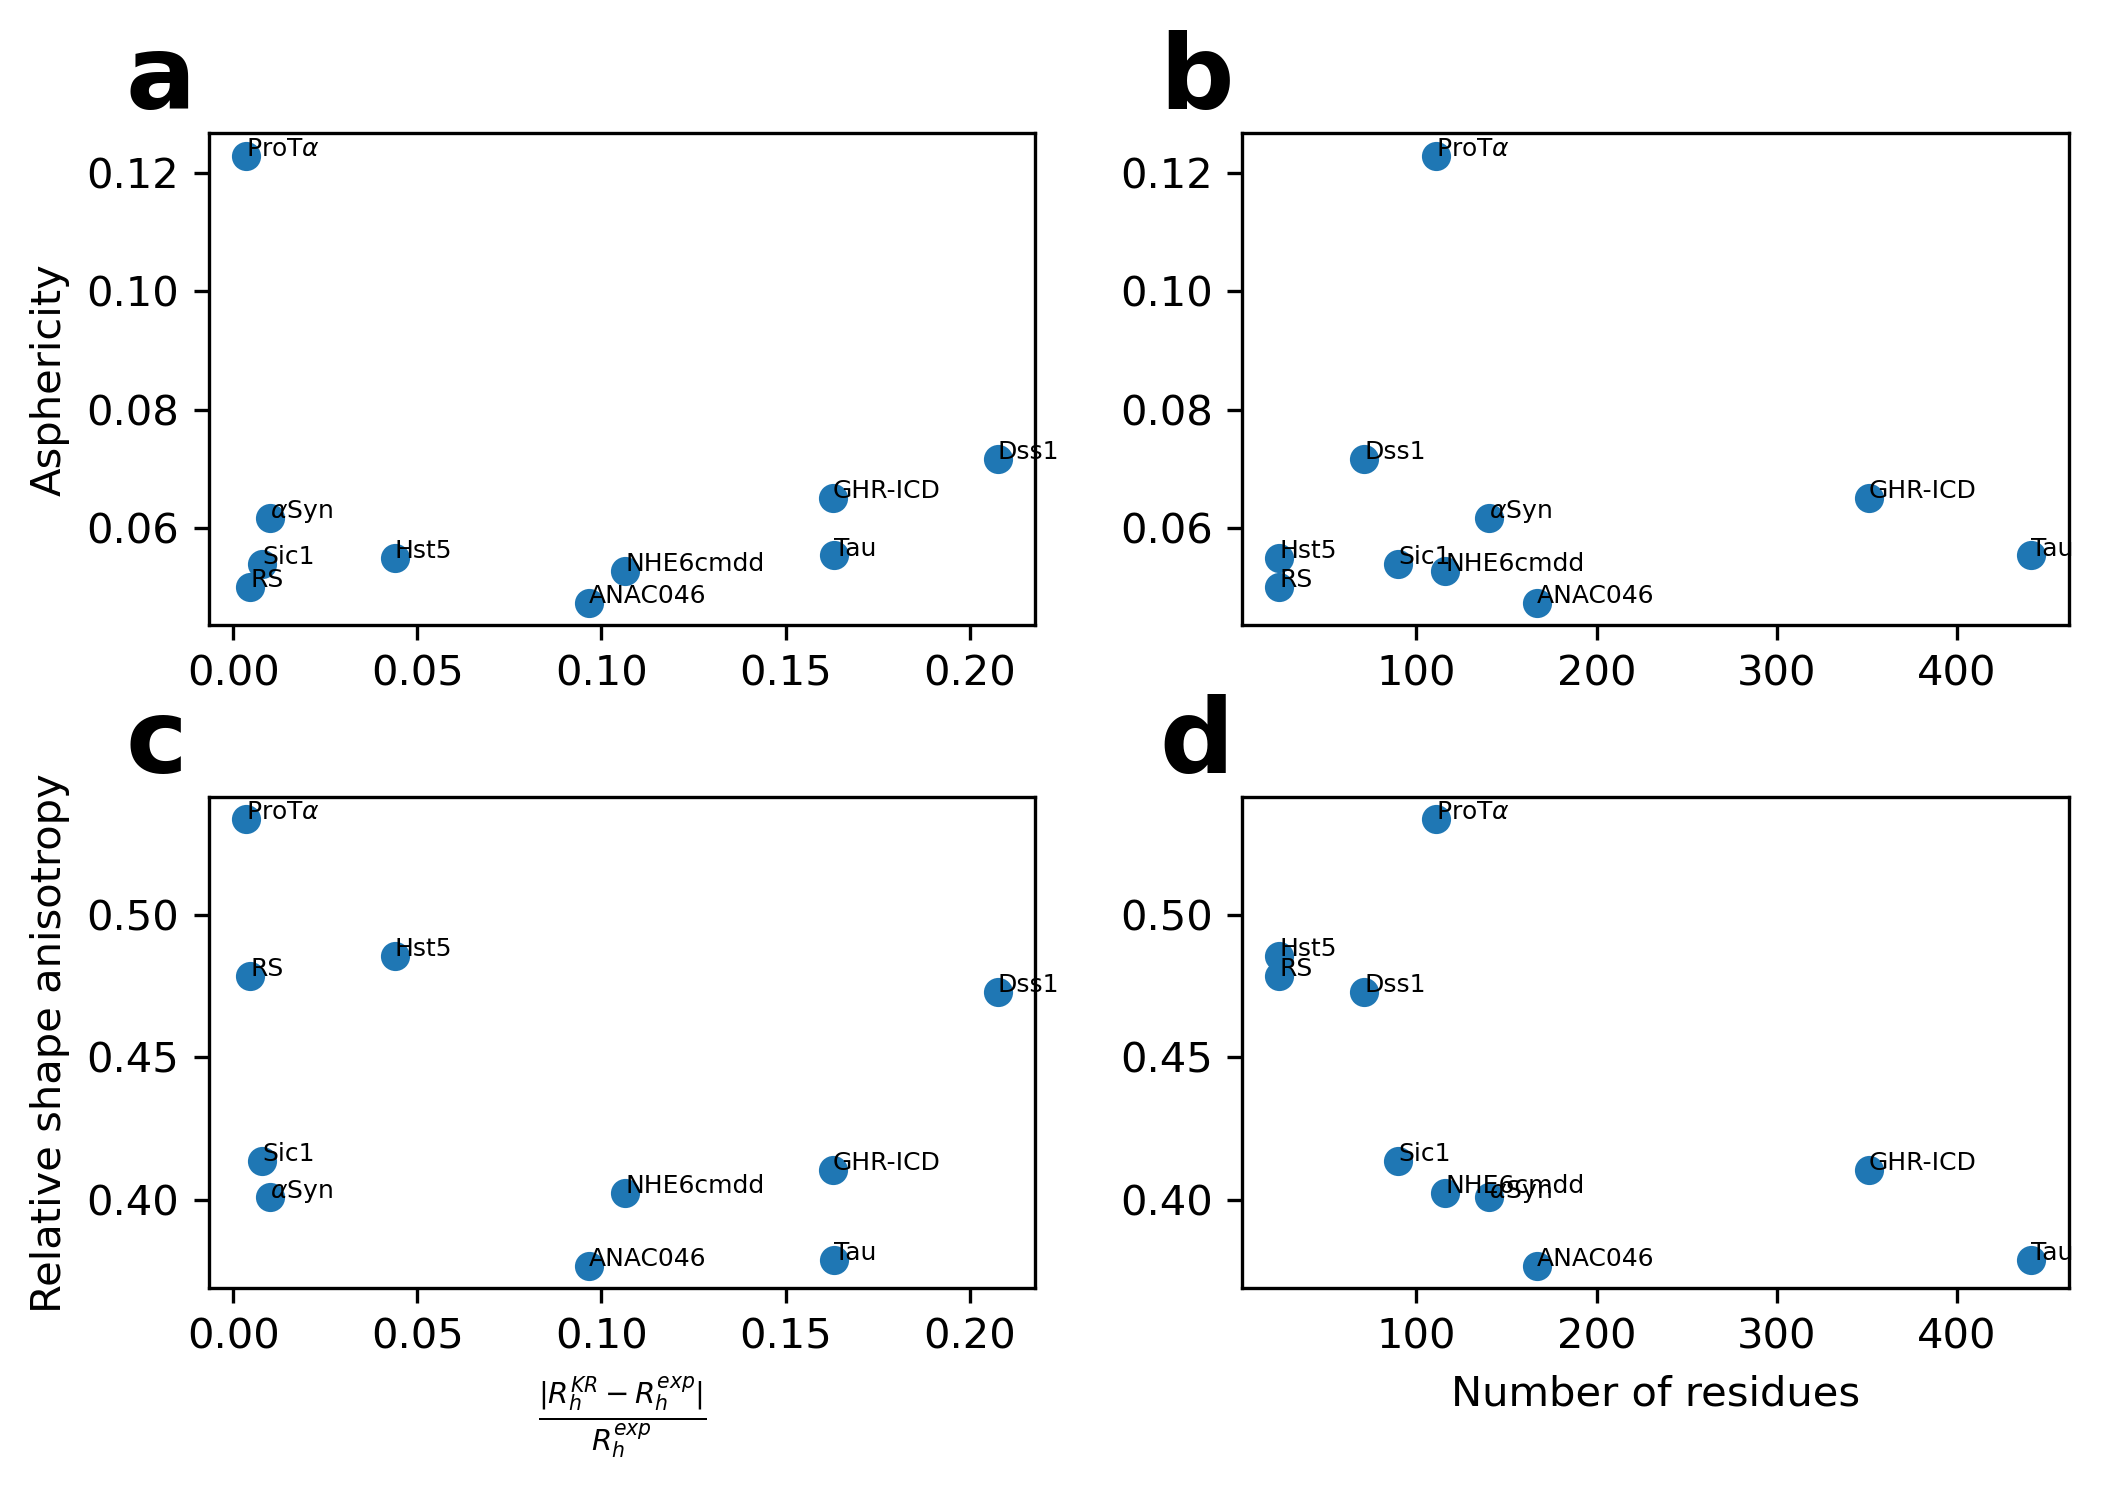

In [885]:
fig, axs = plt.subplots(2,2, figsize=(8,5), gridspec_kw={'hspace':0.35, 'wspace':0.25}, dpi=300, facecolor='w')

av = [asph[p].mean()/dataset.length[p] for p in dataset.index]
axs[0,0].scatter(rel_dev, av)
for i, txt in enumerate(dataset.index):
    axs[0,0].annotate(names_form[i], (rel_dev[i], av[i]), fontsize=6)
axs[0,0].set_ylabel('Asphericity')

axs[0,1].scatter(dataset.length, av)
for i, txt in enumerate(dataset.index):
    axs[0,1].annotate(names_form[i], (dataset.length[i], av[i]), fontsize=6)
    
av = [rel_shape_ani[p].mean() for p in dataset.index]
axs[1,0].scatter(rel_dev, av)
for i, txt in enumerate(dataset.index):
    axs[1,0].annotate(names_form[i], (rel_dev[i], av[i]), fontsize=6)

axs[1,1].scatter(dataset.length, av)
for i, txt in enumerate(dataset.index):
    axs[1,1].annotate(names_form[i], (dataset.length[i], av[i]), fontsize=6)
    
axs[1,0].set_xlabel(r'$\frac{|R_h^{KR}-R_h^{exp}|}{R_h^{exp}}$')
axs[1,1].set_xlabel('Number of residues')
axs[1,0].set_ylabel('Relative shape anisotropy')

for i,ax in enumerate(axs.flatten()):
    ax.text(-0.1,1.05, string.ascii_lowercase[i], fontsize=25, weight='bold', transform=ax.transAxes)

plt.savefig('shape.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

#### Subsampling: 1 frame every 10, resulting in a total of 20000 frames per simulation (i.e. frames taken every 50 ps)

In [188]:
times = np.arange(0,len(traj['DSS1']),10)

In [197]:
for p,t in traj.items():
    os.mkdir(folder+p+'/CG_frames')
    seq3 = [residues.three[x] for x in sequence[p]]
    t = fix_topology(t, seq3)
    c = 0
    for i in times:
        t[i].save_pdb(folder+p+'/CG_frames/frame{}.pdb'.format(c))
        c+=1

### Analyse iBME(SAXS) results for M1

In [19]:
exp_saxs = {}

for p in dataset.index:
    exp_saxs[p] = np.loadtxt(p+'/bift_saxs.txt')
    if exp_saxs[p][...,0][-1] < 1:
        exp_saxs[p][...,0] *= 10

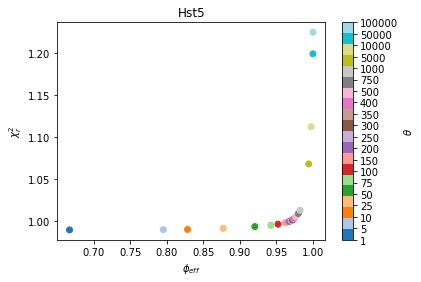

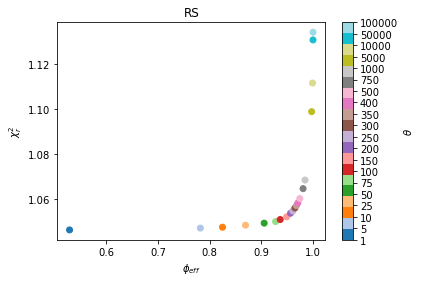

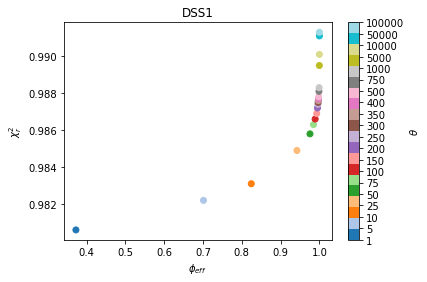

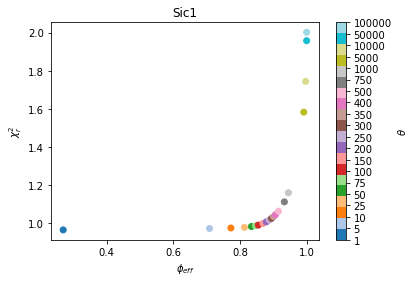

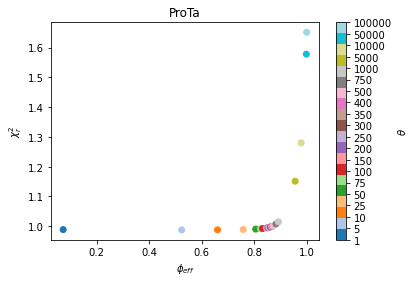

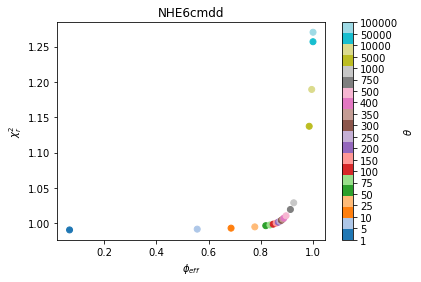

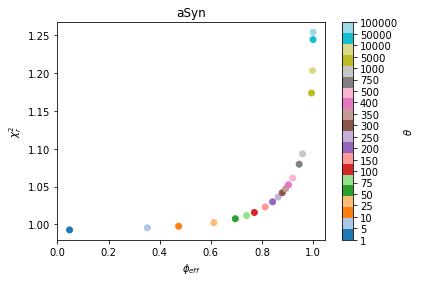

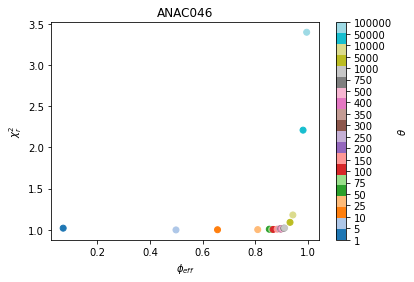

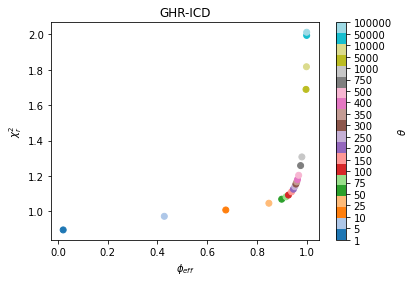

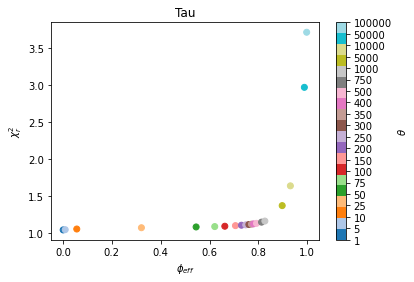

In [20]:
thetas = [ 1, 5, 10, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500, 750, 1000, 5000, 10000, 50000, 100000  ]
BME_tscan_M1 = {}
for idp in dataset.index:
    BME_tscan_M1[idp] = []
    for t in thetas:
        f_ = list(filter(lambda x: x.startswith('t'+str(t)+'_ibme_'), os.listdir(idp+'/BME')))
        f_.sort( key=lambda x: int(x[:-4].split('_')[2]) )
        for l in open(idp+'/BME/'+f_[-1], 'r').readlines():
            if l.startswith('CHI2 after optimization:'):
                chi2 = float(l.split()[-1])
            elif l.startswith('Fraction of effective frames:'):
                phi = float(l.split()[-1])
        BME_tscan_M1[idp].append([t,chi2,phi])
    
    tscan = np.array(BME_tscan_M1[idp])
    #plt.fig = plt.figure(figsize=(3,2))
    plt.scatter(tscan[...,2], tscan[...,1], c=range(len(tscan)), cmap=plt.get_cmap('tab20'))
    cbar = plt.colorbar(ticks=range(len(tscan)), label=r'$\theta$', spacing='uniform')
    cbar.ax.set_yticklabels(thetas)
    plt.title(idp)
    plt.xlabel(r'$\phi_{eff}$')
    plt.ylabel(r'$\chi^2_r$')
    plt.show()

In [21]:
#Choice of thetas
theta_M1 ={
    'Hst5': 250,
    'RS': 150,
    'Sic1': 200,
    'NHE6cmdd': 150,
    'aSyn': 100,
    'ANAC046': 1000,
    'GHR-ICD': 50,
    'Tau': 750,
    'ProTa': 500,
    'DSS1': 25
}

In [393]:
weights_M1 = {}
calc_saxs_M1 = {}
for idp in dataset.index:
    f_ = list(filter(lambda x: x.startswith('t'+str(theta_M1[idp])+'_ibme_'), os.listdir(idp+'/BME')))
    f_.sort( key=lambda x: int(x[:-4].split('_')[2]) )
    conv_ndx = f_[-1][:-4].split('_')[2]
    weights_M1[idp] = np.loadtxt(idp+'/BME/t'+str(theta_M1[idp])+'_'+str(conv_ndx)+'.weights.dat')[...,1] 
    calc_saxs_M1[idp] = np.loadtxt(idp+'/BME/t'+str(theta_M1[idp])+'_'+str(conv_ndx)+'.calc.dat')[...,1:] 

In [23]:
chi2saxs_M1 = []
for i in dataset.index:
    chi2saxs_M1.append(np.array(BME_tscan_M1[i])[...,1][np.array(BME_tscan_M1[i])[...,0] == theta_M1[i]][0])

calc_saxs_ini_M1 = {}
chi2saxs_ini_M1 = []
for i in dataset.index:
    calc = np.average(calc_saxs_M1[i], axis=0)

    exp_i = exp_saxs[i][...,1]
    exp_err = exp_saxs[i][...,2]
    wlr = 1/(exp_err**2)

    model = LinearRegression()
    model.fit(calc.reshape(-1,1),exp_i,wlr)
    a = model.coef_[0]
    b = model.intercept_

    calc = a*calc+b
    calc_saxs_ini_M1[i] = calc
    
    N = len(calc)
    chi2 = ((exp_i - calc)**2 / exp_err**2).sum()
    chi2red = chi2/N
    chi2saxs_ini_M1.append(chi2red)

### Analyse iBME(SAXS) results for FM

In [11]:
BME_tscan_FM = {}
for idp in dataset.index:
    BME_tscan_FM[idp] = []
    for t in thetas:
        f_ = list(filter(lambda x: x.startswith('t'+str(t)+'_ibme_'), os.listdir('FM_old/'+idp+'/BME')))
        f_.sort( key=lambda x: int(x[:-4].split('_')[2]) )
        for l in open('FM_old/'+idp+'/BME/'+f_[-1], 'r').readlines():
            if l.startswith('CHI2 after optimization:'):
                chi2 = float(l.split()[-1])
            elif l.startswith('Fraction of effective frames:'):
                phi = float(l.split()[-1])
        BME_tscan_FM[idp].append([t,chi2,phi])

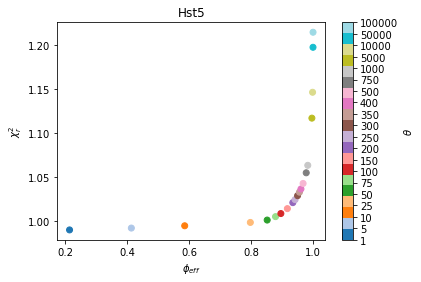

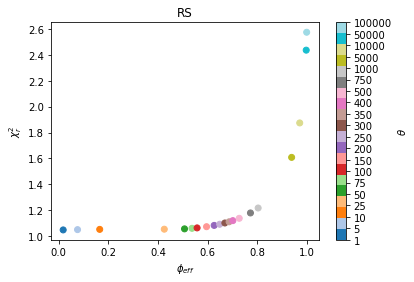

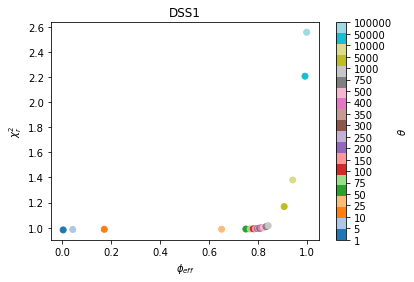

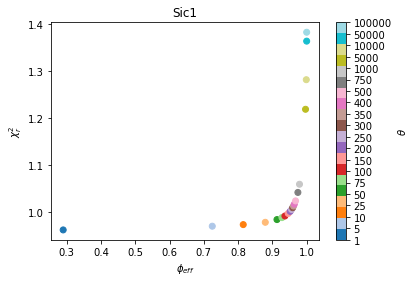

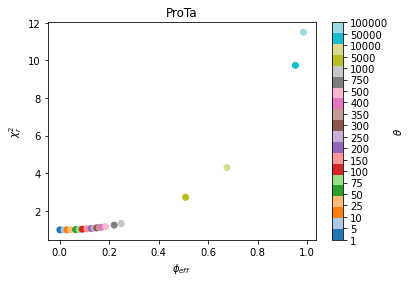

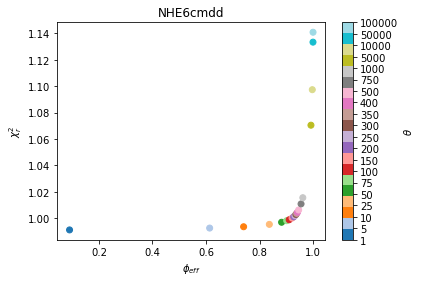

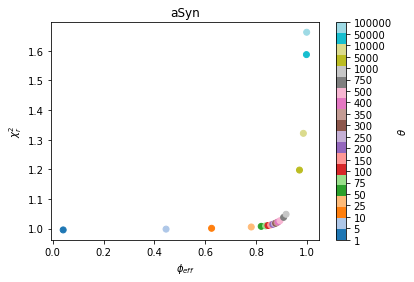

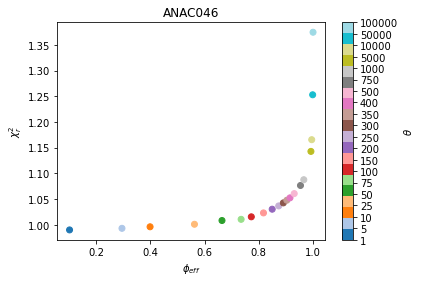

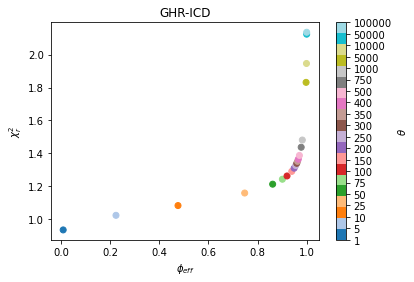

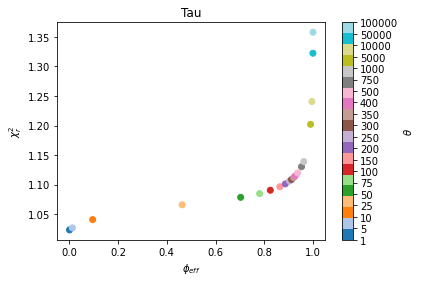

In [12]:
for idp in dataset.index:
    tscan = np.array(BME_tscan_FM[idp])
#    plt.fig = plt.figure(dpi=300)
    plt.scatter(tscan[...,2], tscan[...,1], c=range(len(tscan)), cmap=plt.get_cmap('tab20'))
    cbar = plt.colorbar(ticks=range(len(tscan)), label=r'$\theta$', spacing='uniform')
    cbar.ax.set_yticklabels(thetas)
    plt.title(idp)
    plt.xlabel(r'$\phi_{eff}$')
    plt.ylabel(r'$\chi^2_r$')
    plt.show()

In [13]:
theta_FM = {
    'Hst5': 50,
    'RS': 500,
    'Sic1': 200,
    'NHE6cmdd': 150,
    'aSyn': 150,
    'ANAC046': 150,
    'GHR-ICD': 75,
    'Tau': 150,
    'DSS1': 500,
    'ProTa': 5000
}

In [442]:
weights_FM = {}
calc_saxs_FM = {}
for idp in dataset.index:
    f_ = list(filter(lambda x: x.startswith('t'+str(theta_FM[idp])+'_ibme_'), os.listdir('FM_old/'+idp+'/BME')))
    f_.sort( key=lambda x: int(x[:-4].split('_')[2]) )
    conv_ndx = f_[-1][:-4].split('_')[2]
    weights_FM[idp] = np.loadtxt('FM_old/'+idp+'/BME/t'+str(theta_FM[idp])+'_'+str(conv_ndx)+'.weights.dat')[...,1]  
    calc_saxs_FM[idp] = np.loadtxt('FM_old/'+idp+'/BME/t'+str(theta_FM[idp])+'_'+str(conv_ndx)+'.calc.dat')[...,1:]  

In [18]:
chi2saxs_FM = []
for i in dataset.index:
    chi2saxs_FM.append(np.array(BME_tscan_FM[i])[...,1][np.array(BME_tscan_FM[i])[...,0] == theta_FM[i]][0])

calc_saxs_ini_FM = {}
chi2saxs_ini_FM = []
for i in dataset.index:
    calc = np.average(calc_saxs_FM[i], axis=0)

    exp_i = exp_saxs[i][...,1]
    exp_err = exp_saxs[i][...,2]
    wlr = 1/(exp_err**2)

    model = LinearRegression()
    model.fit(calc.reshape(-1,1),exp_i,wlr)
    a = model.coef_[0]
    b = model.intercept_

    calc = a*calc+b
    calc_saxs_ini_FM[i] = calc
    
    N = len(calc)
    chi2 = ((exp_i - calc)**2 / exp_err**2).sum()
    chi2red = chi2/N
    chi2saxs_ini_FM.append(chi2red)

### Radius of gyration from multiple approaches

In [956]:
def extended_guinier_analysis(saxs, N):
    N = N-1
    gamma = 1.1615
    b = 0.55 #nm
    
    nu_guess = 0.5
    I0_guess = np.average(saxs[...,1][:10])
    
    def f(q, nu, I0):
        rg = np.sqrt( (gamma*(gamma+1)) / (2*(gamma+2*nu)*(gamma+2*nu+1)) ) * b * (N**nu)
        fitI = -1/3 * (q**2) * (rg**2) + 0.0479*(nu - 0.212)*(q**4)*(rg**4)
        fitI = np.exp(fitI)*I0
        return fitI
    
    qmax = 0.3
    qmaxRg = 0
    while qmaxRg <= 2.0:
        ndx = np.where(saxs[...,0]<=qmax)
        q = saxs[...,0][ndx]
        Iexp = saxs[...,1][ndx]
        Ierr = saxs[...,2][ndx]
    
        nu, I0 = curve_fit(f, xdata=q, ydata=Iexp, sigma=Ierr, p0=[nu_guess, I0_guess])[0]
        rg = np.sqrt( (gamma*(gamma+1))/(2*(gamma+2*nu)*(gamma+2*nu+1)) ) * b * (N**nu)
        qmaxRg = qmax*rg
        print ('qmax: {:f} nm; Rg: {:f} nm; qmax*Rg: {:f}'.format(qmax, rg, qmaxRg))
        
        if qmaxRg < 2.:
            Rg = rg
            NU = nu
        qmax += 0.05
        
    return Rg, NU

In [957]:
guinier = [1.34, 1.26, 2.49, 2.86, 3.68, 3.23, 3.56, 3.61, 6.03, 6.36]
guinier_std = [0.05, 0.075, 0.13, 0.14, 0.16, 0.2, 0.036, 0.3, 0.47, 0.52]
guinier_ext_rg = []
guinier_ext_nu = []
mff_rg = [1.39, 1.36, 2.64, 3.06, 3.94, 3.40, 3.68, 3.77, 5.96, 6.66]
mff_rg_std = [0.01, 0.007, 0.004, 0.015, 0.007, 0.014, 0.009, 0.004, 0.038, 0.036]
mff_nu = [0.50, 0.60, 0.57, 0.58, 0.59, 0.55, 0.59, 0.58, 0.56, 0.59]
mff_nu_std = [0.11, 0.037, 0.005, 0.009, 0.003, 0.007, 0.003, 0.001, 0.003, 0.001]

In [959]:
for p in dataset.index:
    rg, nu = extended_guinier_analysis(saxs=exp_saxs[p],N=dataset.length[p])
    guinier_ext_rg.append(rg)
    guinier_ext_nu.append(nu)

qmax: 0.300000 nm; Rg: 1.289727 nm; qmax*Rg: 0.386918
qmax: 0.350000 nm; Rg: 1.388671 nm; qmax*Rg: 0.486035
qmax: 0.400000 nm; Rg: 1.354702 nm; qmax*Rg: 0.541881
qmax: 0.450000 nm; Rg: 1.310302 nm; qmax*Rg: 0.589636
qmax: 0.500000 nm; Rg: 1.325218 nm; qmax*Rg: 0.662609
qmax: 0.550000 nm; Rg: 1.372941 nm; qmax*Rg: 0.755117
qmax: 0.600000 nm; Rg: 1.405340 nm; qmax*Rg: 0.843204
qmax: 0.650000 nm; Rg: 1.417626 nm; qmax*Rg: 0.921457
qmax: 0.700000 nm; Rg: 1.430973 nm; qmax*Rg: 1.001681
qmax: 0.750000 nm; Rg: 1.425920 nm; qmax*Rg: 1.069440
qmax: 0.800000 nm; Rg: 1.413000 nm; qmax*Rg: 1.130400
qmax: 0.850000 nm; Rg: 1.409979 nm; qmax*Rg: 1.198482
qmax: 0.900000 nm; Rg: 1.411010 nm; qmax*Rg: 1.269909
qmax: 0.950000 nm; Rg: 1.404112 nm; qmax*Rg: 1.333906
qmax: 1.000000 nm; Rg: 1.401953 nm; qmax*Rg: 1.401953
qmax: 1.050000 nm; Rg: 1.397998 nm; qmax*Rg: 1.467898
qmax: 1.100000 nm; Rg: 1.395614 nm; qmax*Rg: 1.535176
qmax: 1.150000 nm; Rg: 1.391742 nm; qmax*Rg: 1.600503
qmax: 1.200000 nm; Rg: 1.389

In [960]:
d = {'$R_\text{g}$ (ATSAS)': ['{} $\pm$ {}'.format(np.around(guinier[x],2), np.around(guinier_std[x],2)) for x in range(10)],
     '$R_\text{g}$ (Extended Guinier analysis)': ['{}'.format(np.around(guinier_ext_rg[x],2)) for x in range(10)],
     '$R_\text{g}$ (Molecular Form Factor)': ['{} $\pm$ {}'.format(np.around(mff_rg[x],2), np.around(mff_rg_std[x],2)) for x in range(10)],
     '$\nu$ (Extended Guinier analysis)': ['{}'.format(np.around(guinier_ext_nu[x],2)) for x in range(10)],
     '$\nu$ (Molecular Form Factor)': ['{} $\pm$ {}'.format(np.around(mff_nu[x],2), np.around(mff_nu_std[x],2)) for x in range(10)],
     r'$\frac{R_\text{g} (ATSAS)}/R_{\text{h}}$' : ['{}'.format( np.around(guinier[x]/dataset.Rh.values[x],2)) for x in range(10)]
    }
d = pd.DataFrame(data=d, index=dataset.index)
d.to_latex('rg.tex')

### Comparing FM and M1 ensembles

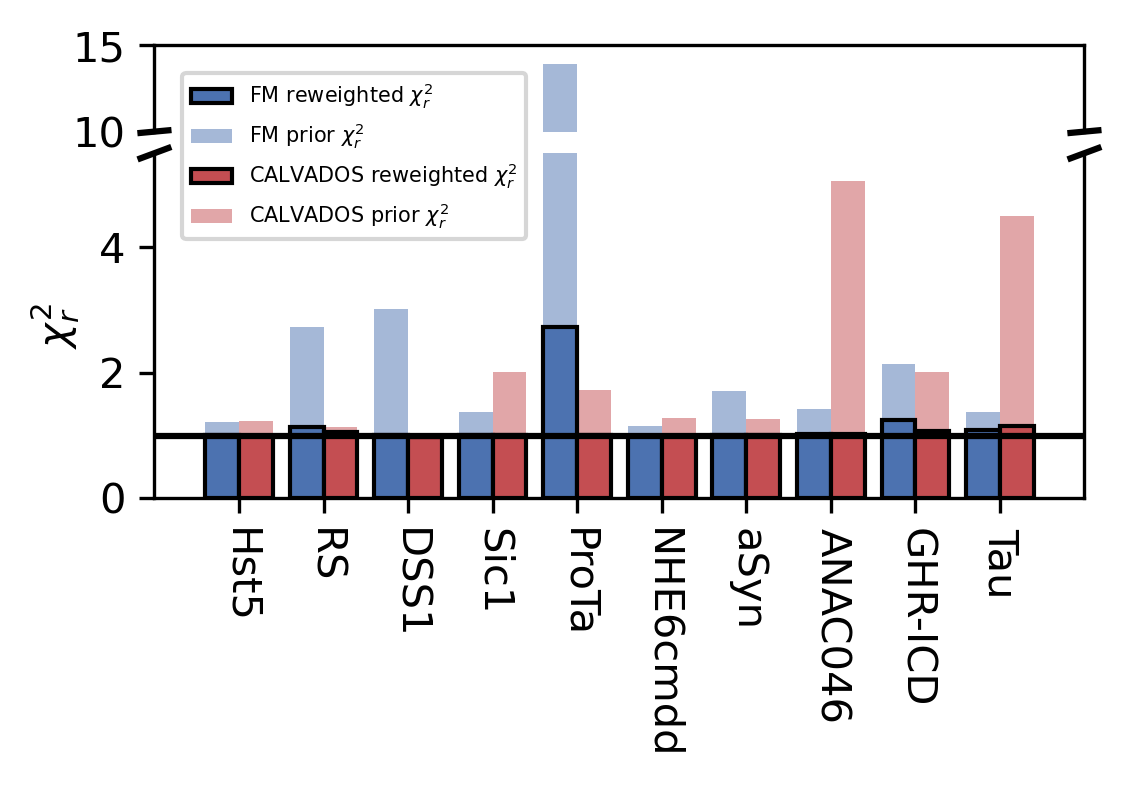

In [87]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 2), dpi=300, gridspec_kw={'height_ratios': [1,4], 'hspace':0.1}, facecolor='w')
for ax in axs:
    ax.bar(np.arange(10)-0.2, chi2saxs_FM,zorder=100, label=r'FM reweighted $\chi^2_r$', edgecolor='k', width=0.4,color=c[0])
    ax.bar(np.arange(10)-0.2, chi2saxs_ini_FM, label=r'FM prior $\chi^2_r$', width=0.4,color=c[0],alpha=0.5)

    ax.bar(np.arange(10)+0.2, chi2saxs_M1,zorder=100, label=r'CALVADOS reweighted $\chi^2_r$', edgecolor='k', width=0.4,color=c[2])
    ax.bar(np.arange(10)+0.2, chi2saxs_ini_M1, color=c[2],alpha=0.5, label=r'CALVADOS prior $\chi^2_r$', width=0.4)
    
axs[0].set_ylim(10, 15)
axs[1].set_ylim(0, 5.5)
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
axs[0].tick_params(labeltop=False)  # don't put tick labels at the top
axs[1].xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False)
axs[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axs[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axs[1].transAxes)  # switch to the bottom axes
axs[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axs[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.xticks(ticks=range(10),labels=dataset.index,rotation=-90)
plt.hlines(1,-1,10,color='k',zorder=200)
plt.xlim(-1,10)
plt.ylim(0,5.5)
plt.ylabel(r'$\chi^2_r$')
axs[1].legend(fontsize=5, loc=(0.03,0.75))
#plt.tight_layout()
plt.savefig('bar_chi2.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

In [ ]:
Rg_Ca_M1 = {}
for p in dataset.index:
    Rg_Ca_M1[p] = []
    for i in range(0,20000):
        conf = md.load_pdb('/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/'+p+'/CG_frames/frame{}.pdb'.format(i))
        Rg_Ca_M1[p].append( md.compute_rg(conf)[0] )

In [ ]:
FM_ens_size = {
    'Hst5': 10000,
    'RS': 10000,
    'DSS1': 15000,
    'Sic1': 15000,
    'ProTa': 15000,
    'NHE6cmdd': 15000,
    'aSyn': 20000,
    'ANAC046': 20000,
    'GHR-ICD': 25000,
    'Tau': 30000 
}

In [ ]:
Rg_Ca_FM = {}
for p in dataset.index:
    Rg_Ca_FM[p] = []
    for i in range(0, FM_ens_size[p]):
        conf = md.load_pdb('/storage1/francesco/PROJECTS/ENSEMBLES/'+p+'/FM/frame{}.pdb'.format(i))
        conf = conf.atom_slice(conf.top.select('name CA'),inplace=True)
        Rg_Ca_FM[p].append( md.compute_rg(conf)[0] )

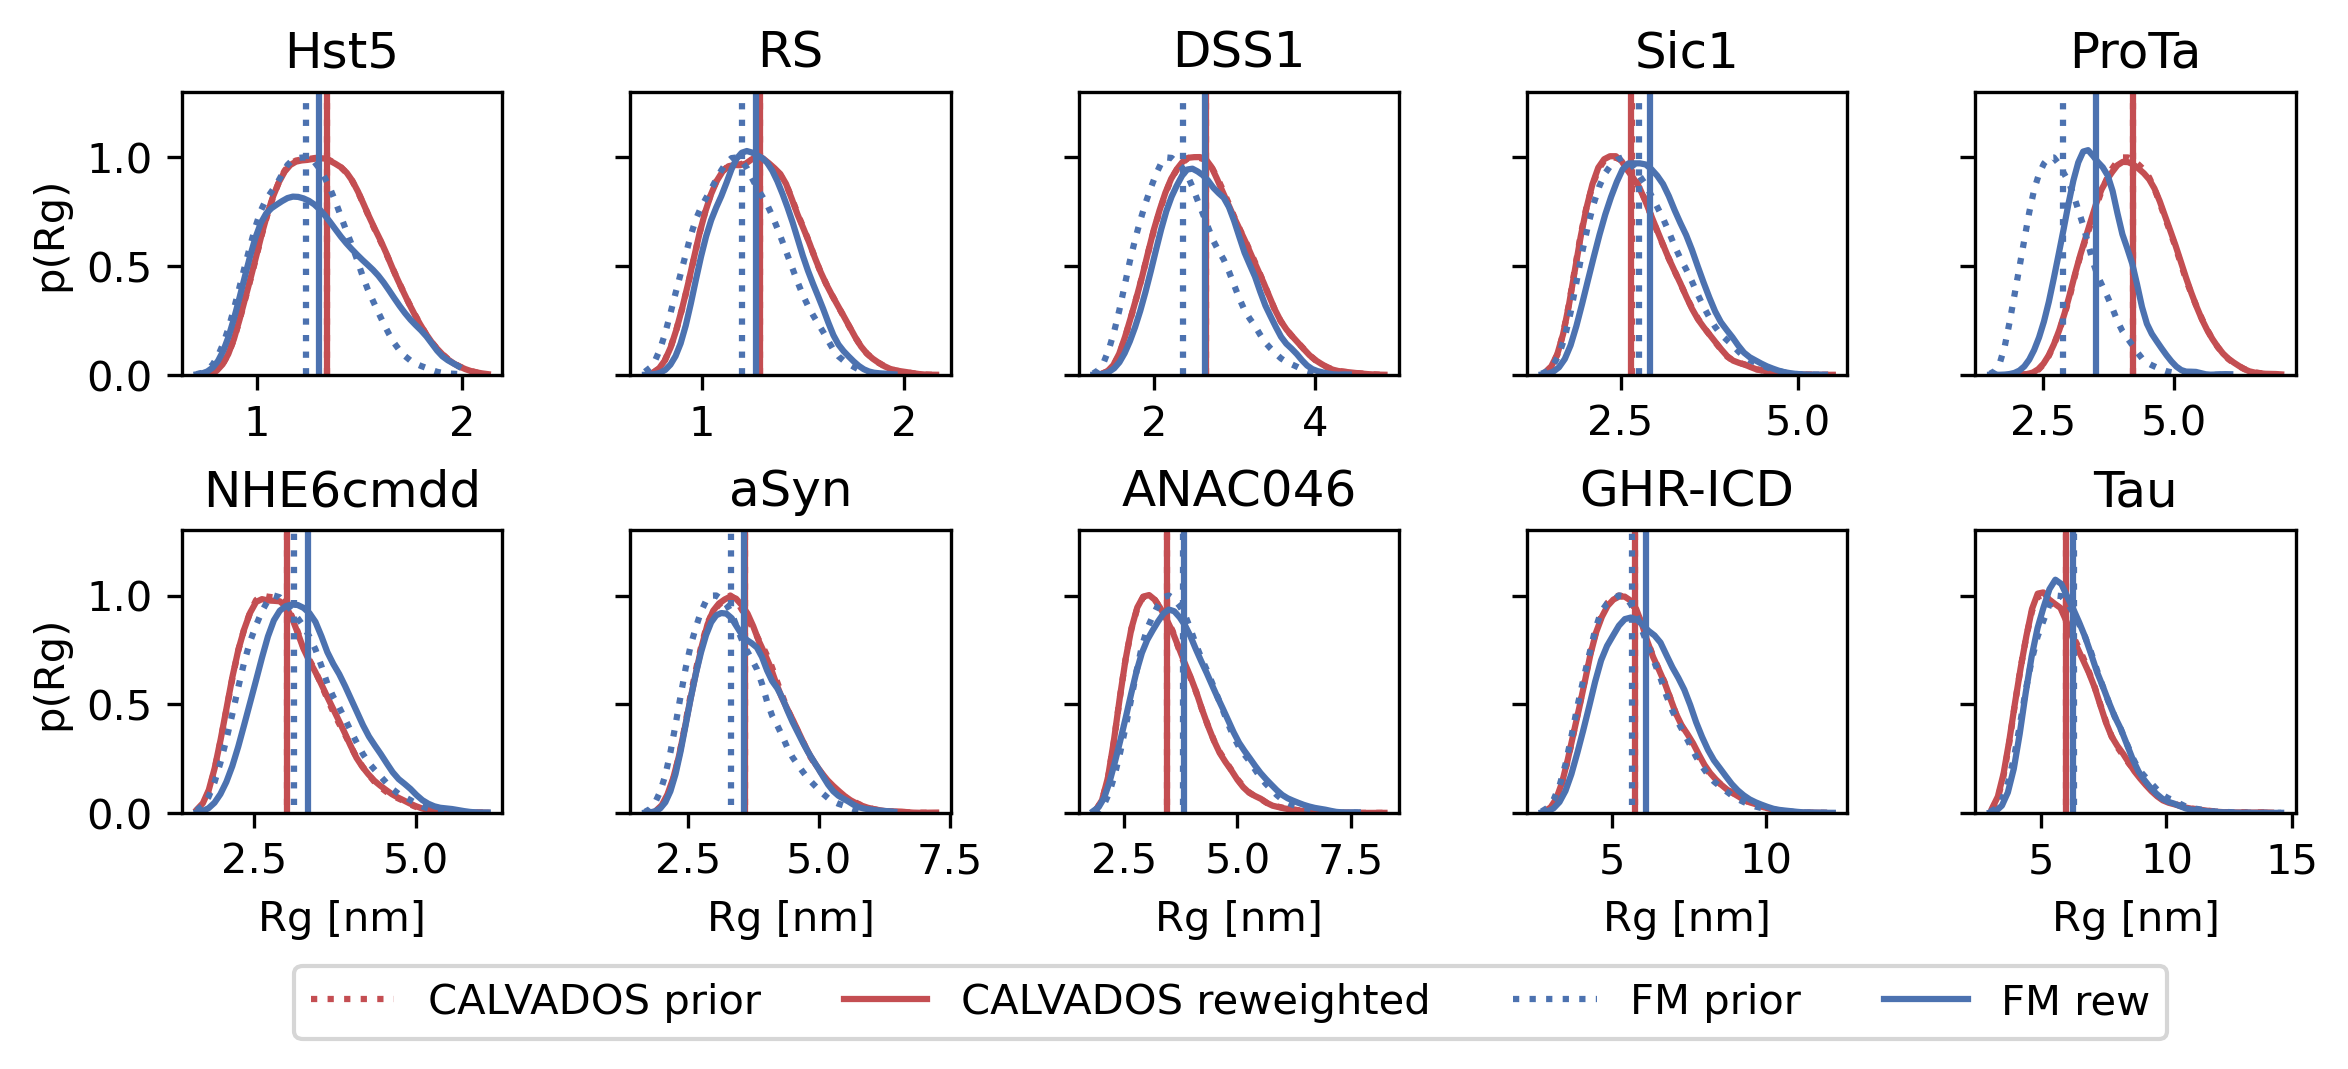

In [1084]:
fig, axs = plt.subplots(2, 5, figsize=(10/1.1,3.5/1.1), gridspec_kw={'hspace':0.55, 'wspace':0.4}, dpi=300, facecolor='w', sharey=True)
for p,ax in zip(dataset.index, axs.flatten()):
    stat_m1 = kde_rg( np.array(Rg_Ca_M1[p]) )
    stat_m1_rew = kde_rg(np.array(Rg_Ca_M1[p]), w=weights_M1[p])
    
    stat_fm = kde_rg( np.array(Rg_Ca_FM[p]) )
    stat_fm_rew = kde_rg(np.array(Rg_Ca_FM[p]), w=weights_FM[p])
    
    l0 = ax.plot(stat_m1[0], stat_m1[1]/stat_m1[1].max(), label='CALVADOS prior',color=c[2], ls='dotted')
    ax.vlines(stat_m1[2],-10,10,color=c[2], ls='dotted')
    l1 = ax.plot(stat_m1_rew[0], stat_m1_rew[1]/stat_m1[1].max(), label='CALVADOS reweighted',color=c[2])
    ax.vlines(stat_m1_rew[2],-10,10,color=c[2])
    
    l2 = ax.plot(stat_fm[0], stat_fm[1]/stat_fm[1].max(), label='FM prior',color=c[0], ls='dotted')
    ax.vlines(stat_fm[2],-10,10,color=c[0], ls='dotted')
    l3 = ax.plot(stat_fm_rew[0], stat_fm_rew[1]/stat_fm[1].max(), label='FM rew',color=c[0])
    ax.vlines(stat_fm_rew[2],-10,10,color=c[0])
    
    ax.set_title(p)
    #ax.set_ylim(0,np.max( [stat_m1[1].max(), stat_fm[1].max(), stat_m1_rew[1].max(), stat_fm_rew[1].max()])+0.15)
    ax.set_ylim(0,1.3)
    
axs[0,0].set_ylabel('p(Rg)')
axs[-1,-1].legend(fontsize=10, ncol=4, loc=(-5.25,-0.8))
axs[1,0].set_ylabel('p(Rg)')
for ax in axs.flatten()[5:]:
    ax.set_xlabel('Rg [nm]')
plt.savefig('rg_fm_m1.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

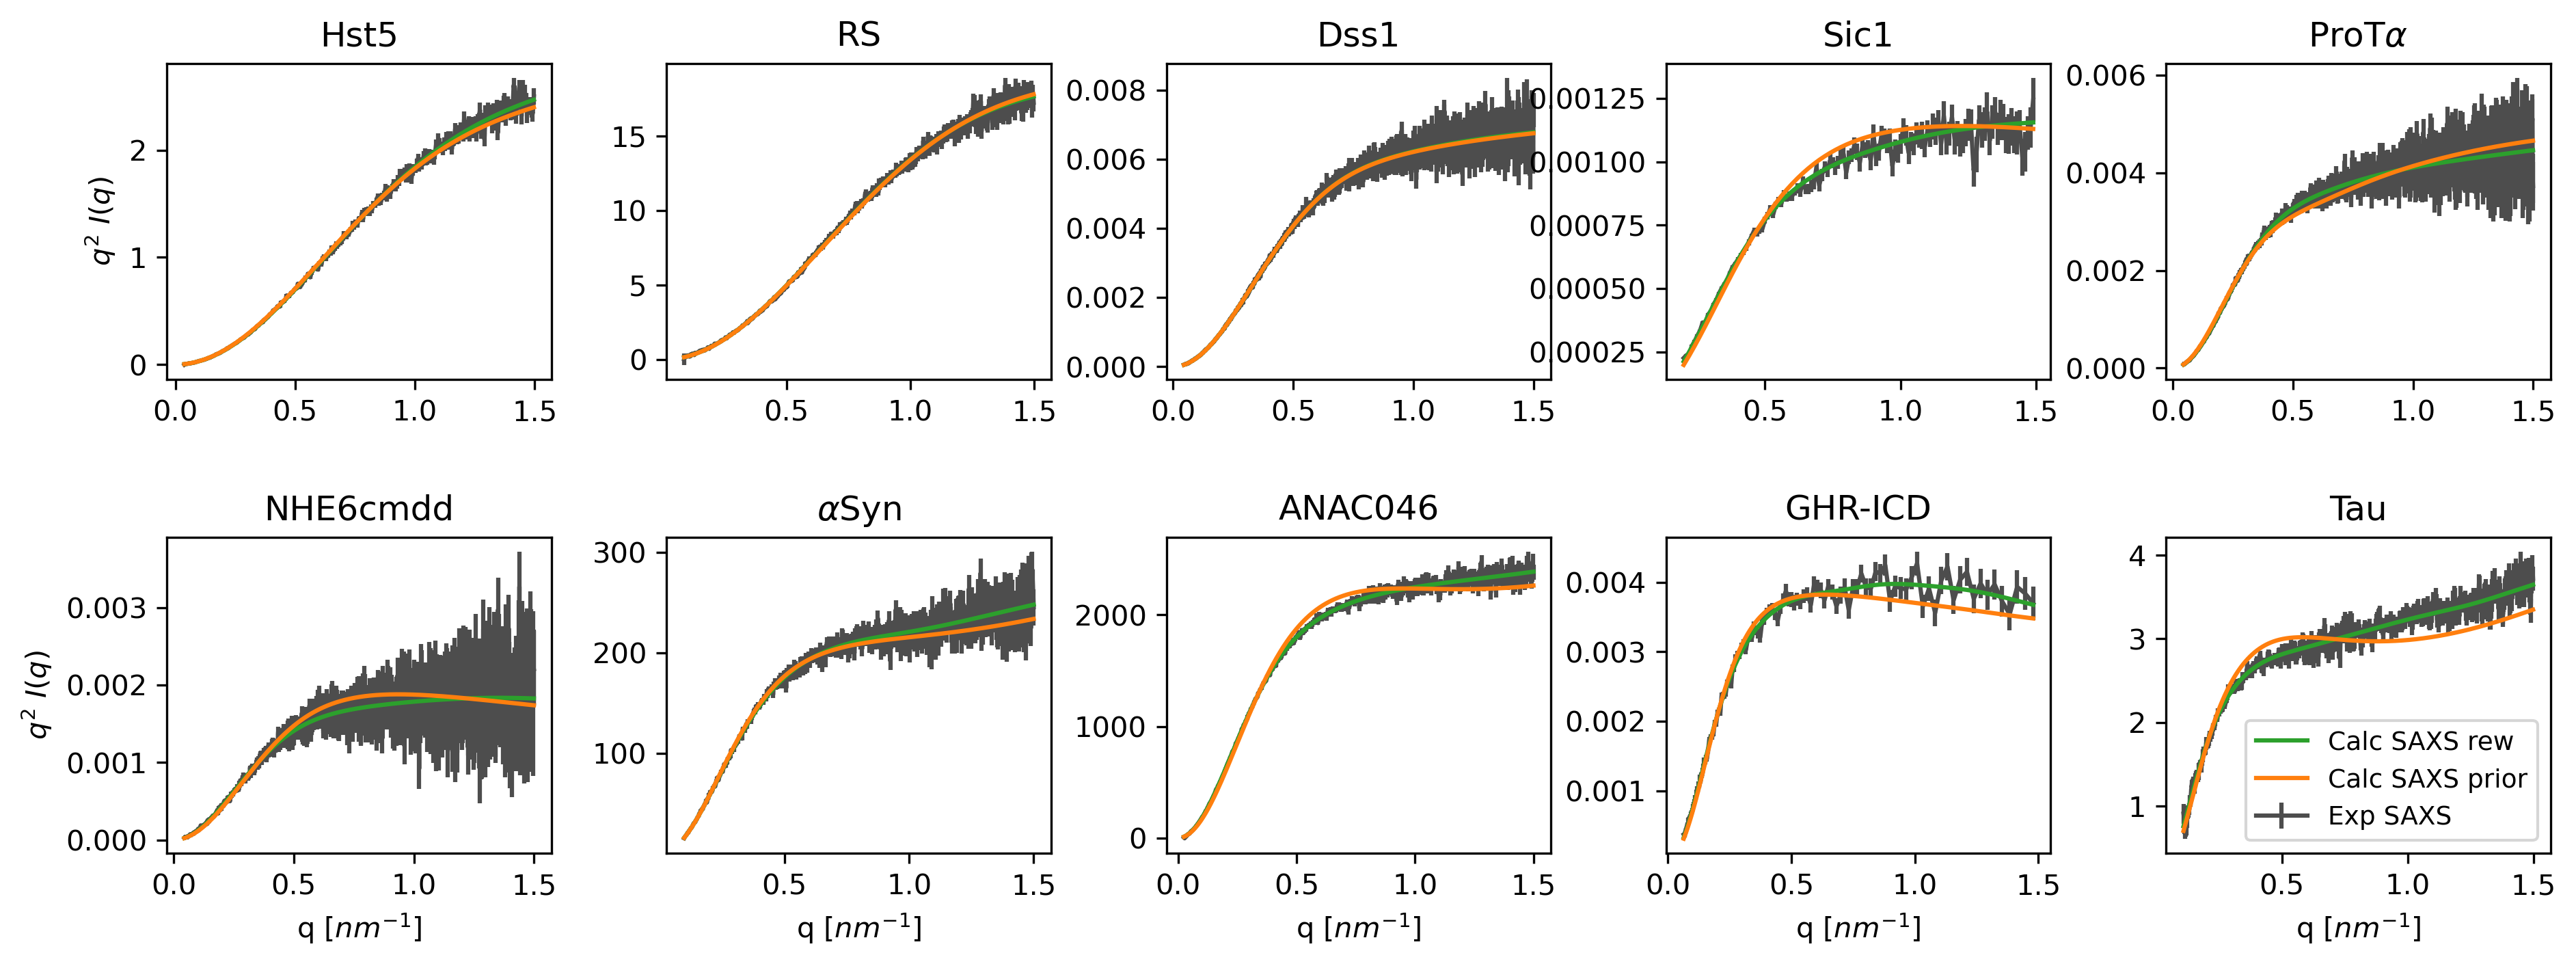

In [886]:
fig, axs = plt.subplots(2, 5, figsize=(15,5), gridspec_kw={'hspace':0.5, 'wspace':0.3}, dpi=300)
for i, (p,ax) in enumerate(zip(dataset.index, axs.flatten())):
    ndx = exp_saxs[p][...,0] < 1.5
    
    q = exp_saxs[p][...,0]
    kratky_exp = (q**2)*exp_saxs[p][...,1]
    kratky_err = (q**2)*exp_saxs[p][...,2]
    calc_i = np.average( calc_saxs_M1[p], weights=weights_M1[p], axis=0 )
    kratky_calc_rew = (q**2)*calc_i
    kratky_calc_ini = (q**2)*calc_saxs_ini_M1[p]
    
    ax.errorbar(q[ndx] ,kratky_exp[ndx] ,kratky_err[ndx], label='Exp SAXS',c='0.3')
    ax.plot(q[ndx], kratky_calc_rew[ndx] ,zorder=100, label='Calc SAXS rew',c=c[2])
    ax.plot(q[ndx], kratky_calc_ini[ndx] ,zorder=100, label='Calc SAXS prior',c=c[1])
    
    ax.set_title(names_form[i])
    
axs[0,0].set_ylabel(r'$q^2$ $I(q)$')
axs[1,0].set_ylabel(r'$q^2$ $I(q)$')
for ax in axs.flatten()[5:]:
    ax.set_xlabel(r'q [$nm^{-1}$]')
axs[-1,-1].legend(fontsize=9)
plt.savefig('saxs_m1.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

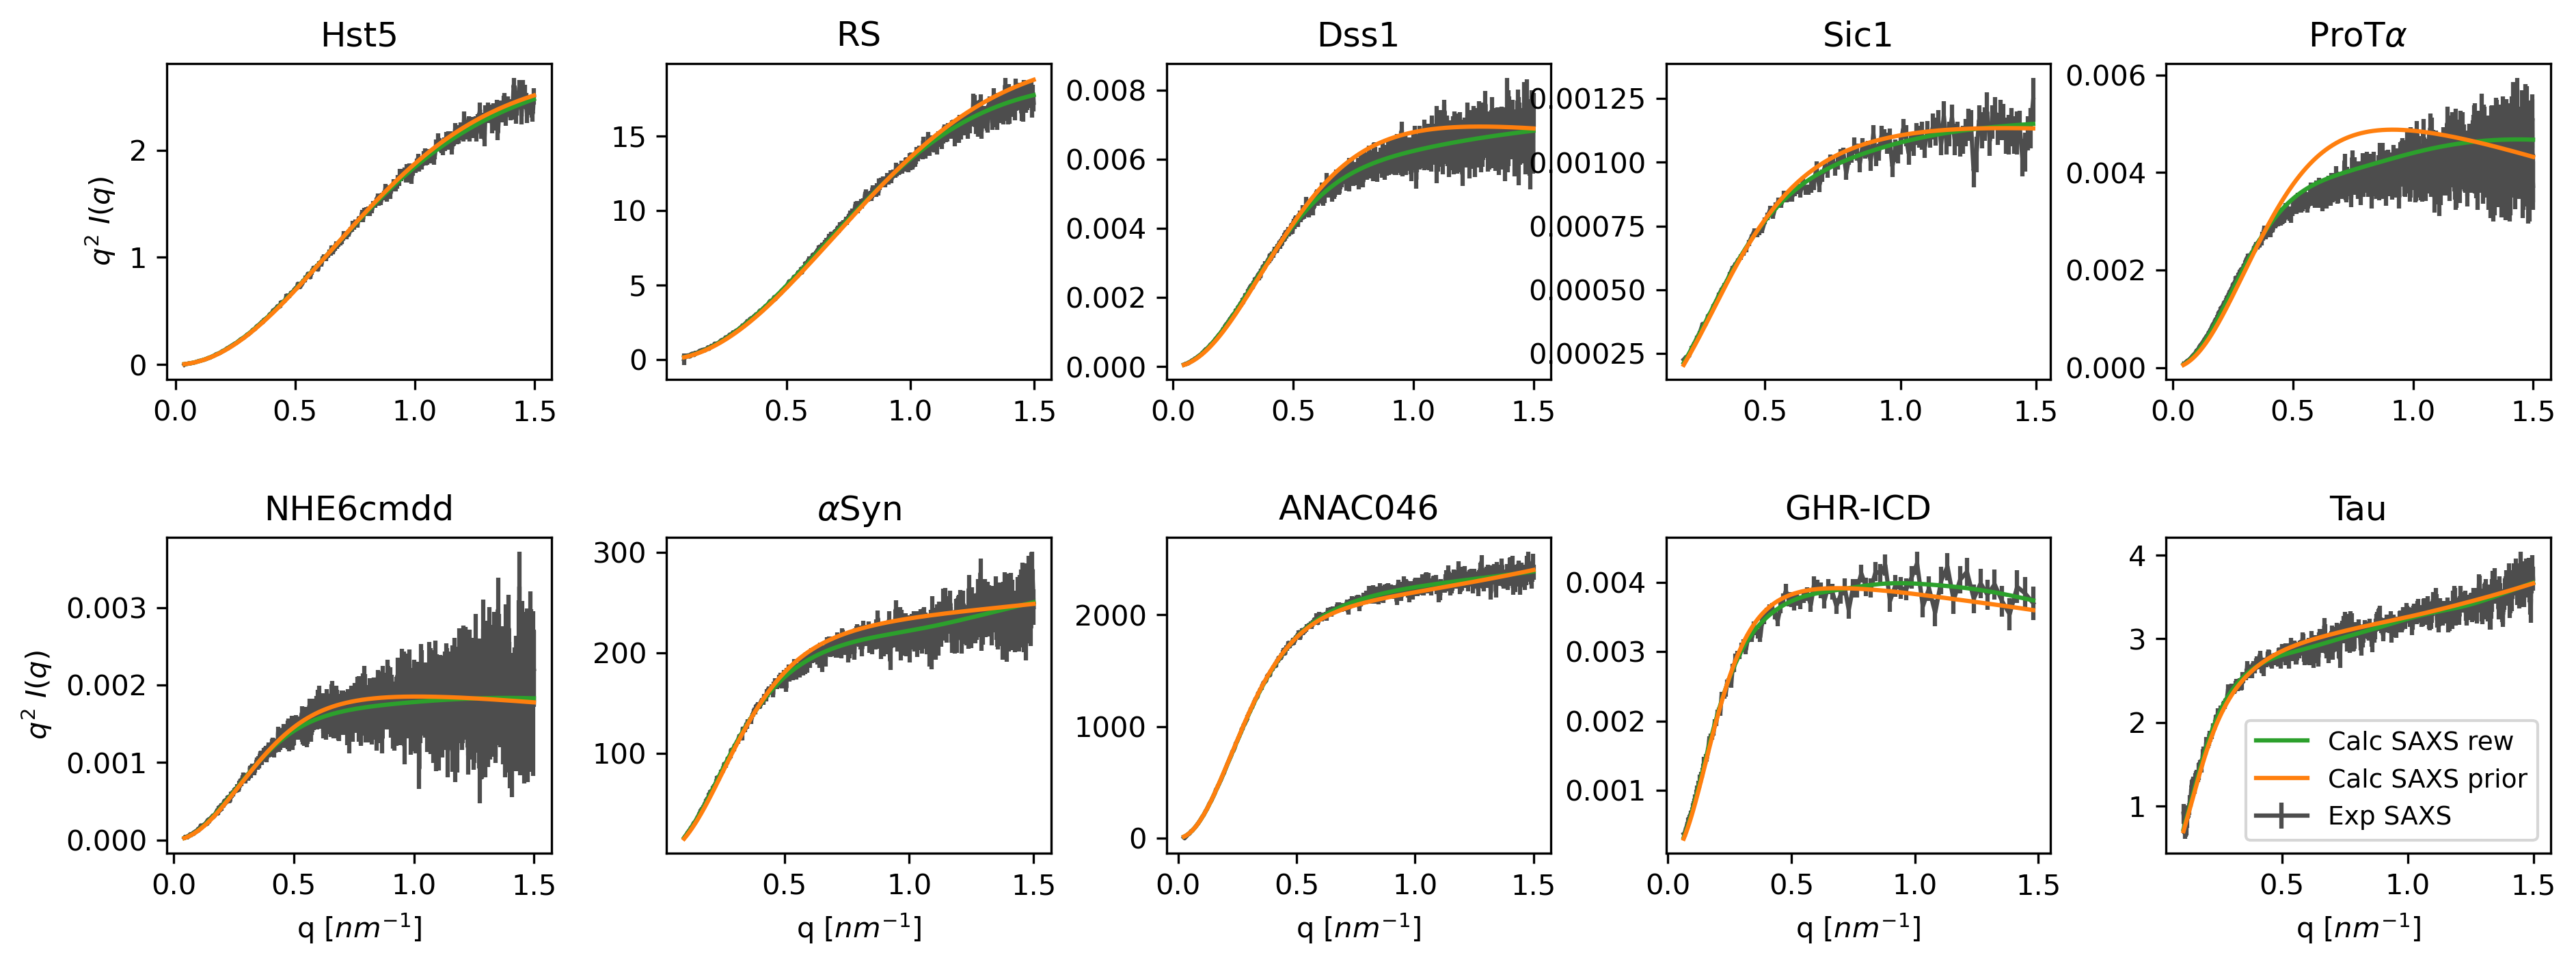

In [887]:
fig, axs = plt.subplots(2, 5, figsize=(15,5), gridspec_kw={'hspace':0.5, 'wspace':0.3}, dpi=300)
for i, (p,ax) in enumerate(zip(dataset.index, axs.flatten())):
    ndx = exp_saxs[p][...,0] < 1.5
    
    q = exp_saxs[p][...,0]
    kratky_exp = (q**2)*exp_saxs[p][...,1]
    kratky_err = (q**2)*exp_saxs[p][...,2]
    calc_i = np.average( calc_saxs_FM[p], weights=weights_FM[p], axis=0 )
    kratky_calc_rew = (q**2)*calc_i
    kratky_calc_ini = (q**2)*calc_saxs_ini_FM[p]
    
    ax.errorbar(q[ndx] ,kratky_exp[ndx] ,kratky_err[ndx], label='Exp SAXS',c='0.3')
    ax.plot(q[ndx], kratky_calc_rew[ndx] ,zorder=100, label='Calc SAXS rew',c=c[2])
    ax.plot(q[ndx], kratky_calc_ini[ndx] ,zorder=100, label='Calc SAXS prior',c=c[1])
    
    ax.set_title(names_form[i])

axs[0,0].set_ylabel(r'$q^2$ $I(q)$')
axs[1,0].set_ylabel(r'$q^2$ $I(q)$')
for ax in axs.flatten()[5:]:
    ax.set_xlabel(r'q [$nm^{-1}$]')
axs[-1,-1].legend(fontsize=9)
plt.savefig('saxs_fm.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

### Rh forward models comparison - M1

In [394]:
Rh_Nyg = {}
Rh_Kirk = {}
Rh_HR = {}
Rh_KirkNyg = {}
for p in dataset.index:
    Rh_Nyg[p] = kde( np.loadtxt(p+'/Rh_Nyg.dat')/10, weights_M1[p] )
    Rh_Kirk[p] = kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat'), weights_M1[p] )
    Rh_HR[p] = kde( np.loadtxt(p+'/Rh_HR.dat'), weights_M1[p])
    Rh_KirkNyg[p] = kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat')*1.186+0.103, weights_M1[p] )

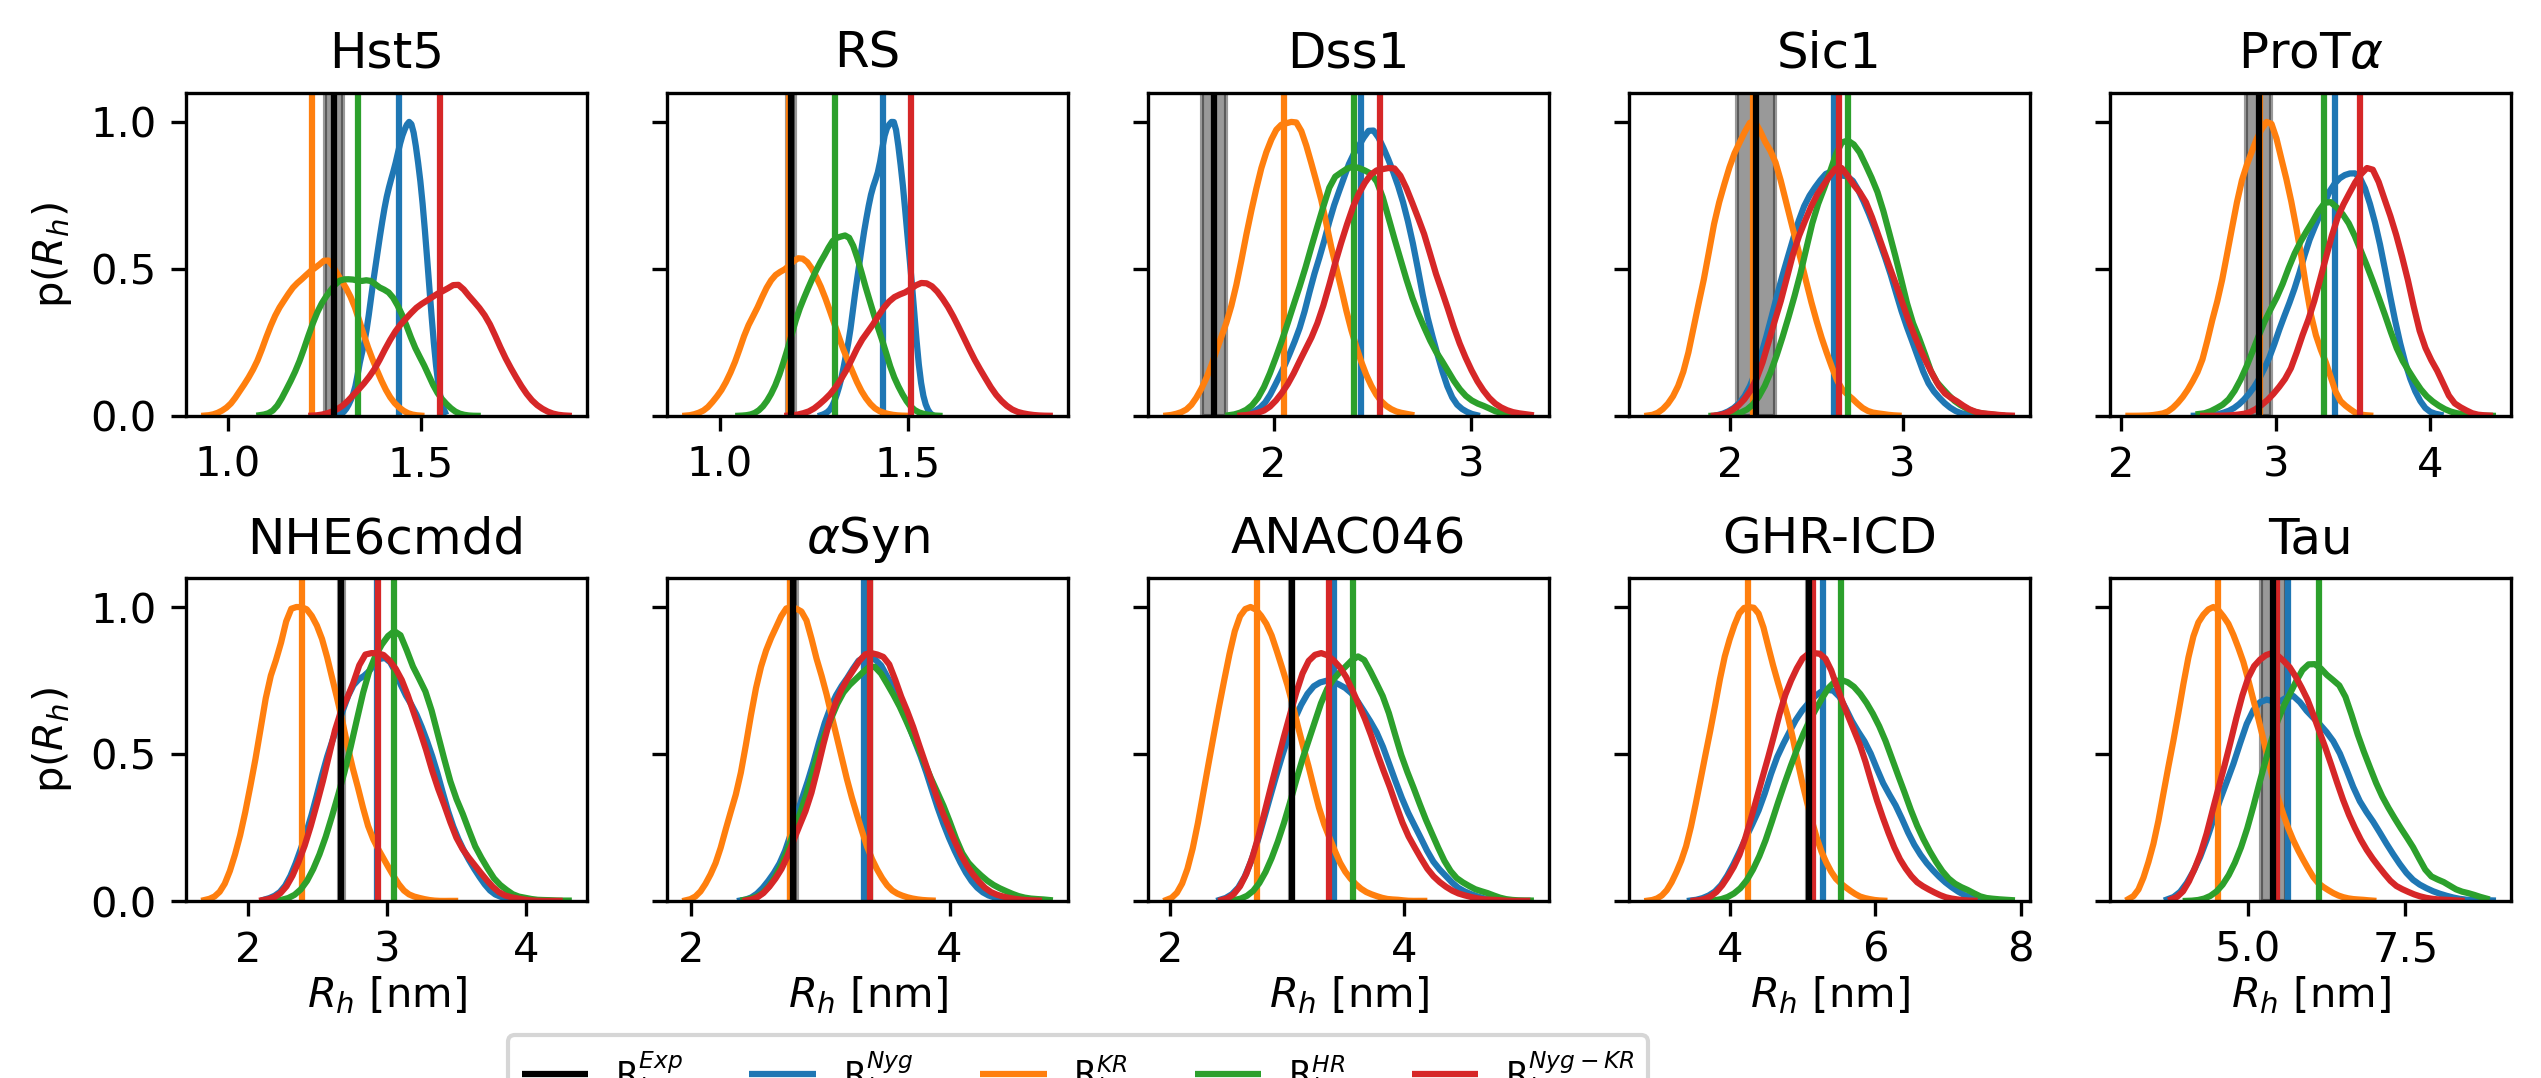

In [882]:
fig, axs = plt.subplots(2, 5, figsize=(10,3.5), gridspec_kw={'hspace':0.5, 'wspace':0.2}, sharey=True, dpi=300, facecolor='w')
for i,(p,ax) in enumerate(zip(dataset.index, axs.flatten())):
    scale = np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )
    
    ax.plot(Rh_Nyg[p][0], Rh_Nyg[p][1]/scale, label=r'Nygaard ($R_g$)',color=c[0])
    l1 = ax.vlines(Rh_Nyg[p][2],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,color=c[0])
    
    ax.plot(Rh_Kirk[p][0], Rh_Kirk[p][1]/scale, label='Kirkwood',color=c[1])
    l2 = ax.vlines(Rh_Kirk[p][2],Rh_Kirk[p][1].min()-1,Rh_Kirk[p][1].max()+10,color=c[1])
    
    ax.plot(Rh_HR[p][0], Rh_HR[p][1]/scale, label='HullRad',color=c[2])
    l3 = ax.vlines(Rh_HR[p][2],Rh_HR[p][1].min()-1,Rh_HR[p][1].max()+10,color=c[2])
    
    ax.plot(Rh_KirkNyg[p][0], Rh_KirkNyg[p][1]/scale, label='Nygaard (Kirkwood)',color=c[3])
    l4 = ax.vlines(Rh_KirkNyg[p][2],Rh_KirkNyg[p][1].min()-1,Rh_KirkNyg[p][1].max()+10,color=c[3])
    
    l0 = ax.vlines(dataset.Rh[p],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,label='Exp',color='k')
    #ax.set_ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
    ax.set_ylim(0,1.1)
    ax.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
    ax.set_title(names_form[i])

axs[0,0].set_ylabel(r'p($R_h$)')
axs[1,0].set_ylabel(r'p($R_h$)')
for ax in axs.flatten()[5:]:
    ax.set_xlabel(r'$R_h$ [nm]', labelpad=1)
#axs[0,0].legend(fontsize=5)
plt.figlegend( (l0,l1,l2,l3,l4), (r'R$_h^{Exp}$' ,r'R$_h^{Nyg}$', r'R$_h^{KR}$', r'R$_h^{HR}$', r'R$_h^{Nyg-KR}$'), loc =(0.2, -0.03), ncol=5, fontsize=8 )
plt.savefig('rh_fwdmod_m1.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

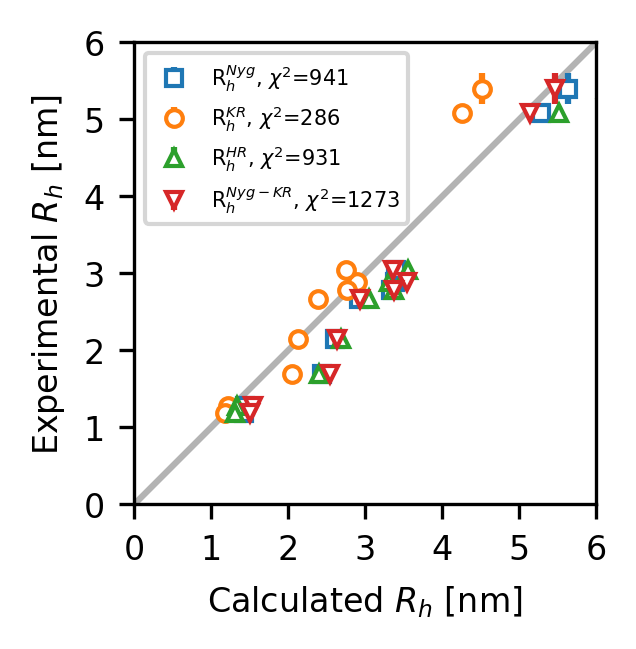

In [900]:
mpl.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(2,2), dpi=300)

ax.set_box_aspect(1)
ax.plot([0,100], [0,100], c='0.7')
ax.errorbar([v[2] for x,v in Rh_Nyg.items()], dataset.Rh, dataset.Rh_err, fmt='s', mfc='w', label=r'R$_h^{Nyg}$, $\chi^2$=941' ,ms=4,alpha=1)
ax.errorbar([v[2] for x,v in Rh_Kirk.items()], dataset.Rh, dataset.Rh_err, fmt='o', mfc='w', label=r'R$_h^{KR}$, $\chi^2$=286' ,ms=4,alpha=1)
ax.errorbar([v[2] for x,v in Rh_HR.items()], dataset.Rh, dataset.Rh_err, fmt='^', mfc='w', label=r'R$_h^{HR}$, $\chi^2$=931' ,ms=4,alpha=1)
ax.errorbar([v[2] for x,v in Rh_KirkNyg.items()], dataset.Rh, dataset.Rh_err, fmt='v', mfc='w', label=r'R$_h^{Nyg-KR}$, $\chi^2$=1273' ,ms=4,alpha=1)
ax.set_xlabel(r'Calculated $R_h$ [nm]')
ax.set_ylabel(r'Experimental $R_h$ [nm]')
ax.set_ylim(0,6)
ax.set_xlim(0,6)
plt.legend(fontsize=5)
ax.set_xticks(np.arange(7),np.arange(0,7))

plt.savefig('rh_fwmod.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

In [901]:
chi2 = ([v[2] for x,v in Rh_Nyg.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('Nygaard', chi2.sum())

chi2 = ([v[2] for x,v in Rh_Kirk.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('Kirkwood', chi2.sum())

chi2 = ([v[2] for x,v in Rh_HR.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('HullRad', chi2.sum())

chi2 = ([v[2] for x,v in Rh_KirkNyg.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('Kirkwood-Nygaard', chi2.sum())

Nygaard 941.48357788465
Kirkwood 286.4152685618354
HullRad 931.4710310177273
Kirkwood-Nygaard 1272.6636706072472


### Rh forward models comparison - FM

In [441]:
Rh_Nyg_FM = {}
Rh_Kirk_FM = {}
Rh_HR_FM = {}
Rh_KirkNyg_FM = {}
for p in dataset.index:
    Rh_Nyg_FM[p] = kde( np.loadtxt('FM_old/'+p+'/Rh_Nyg.dat')/10, weights_FM[p] )
    Rh_Kirk_FM[p] = kde( np.loadtxt('FM_old/'+p+'/Rh_Kirk_Ca.dat'), weights_FM[p] )
    Rh_HR_FM[p] = kde( np.loadtxt('FM_old/'+p+'/Rh_HR.dat'), weights_FM[p])
    Rh_KirkNyg_FM[p] = kde( np.loadtxt('FM_old/'+p+'/Rh_Kirk_Ca.dat')*1.186+0.103, weights_FM[p] )

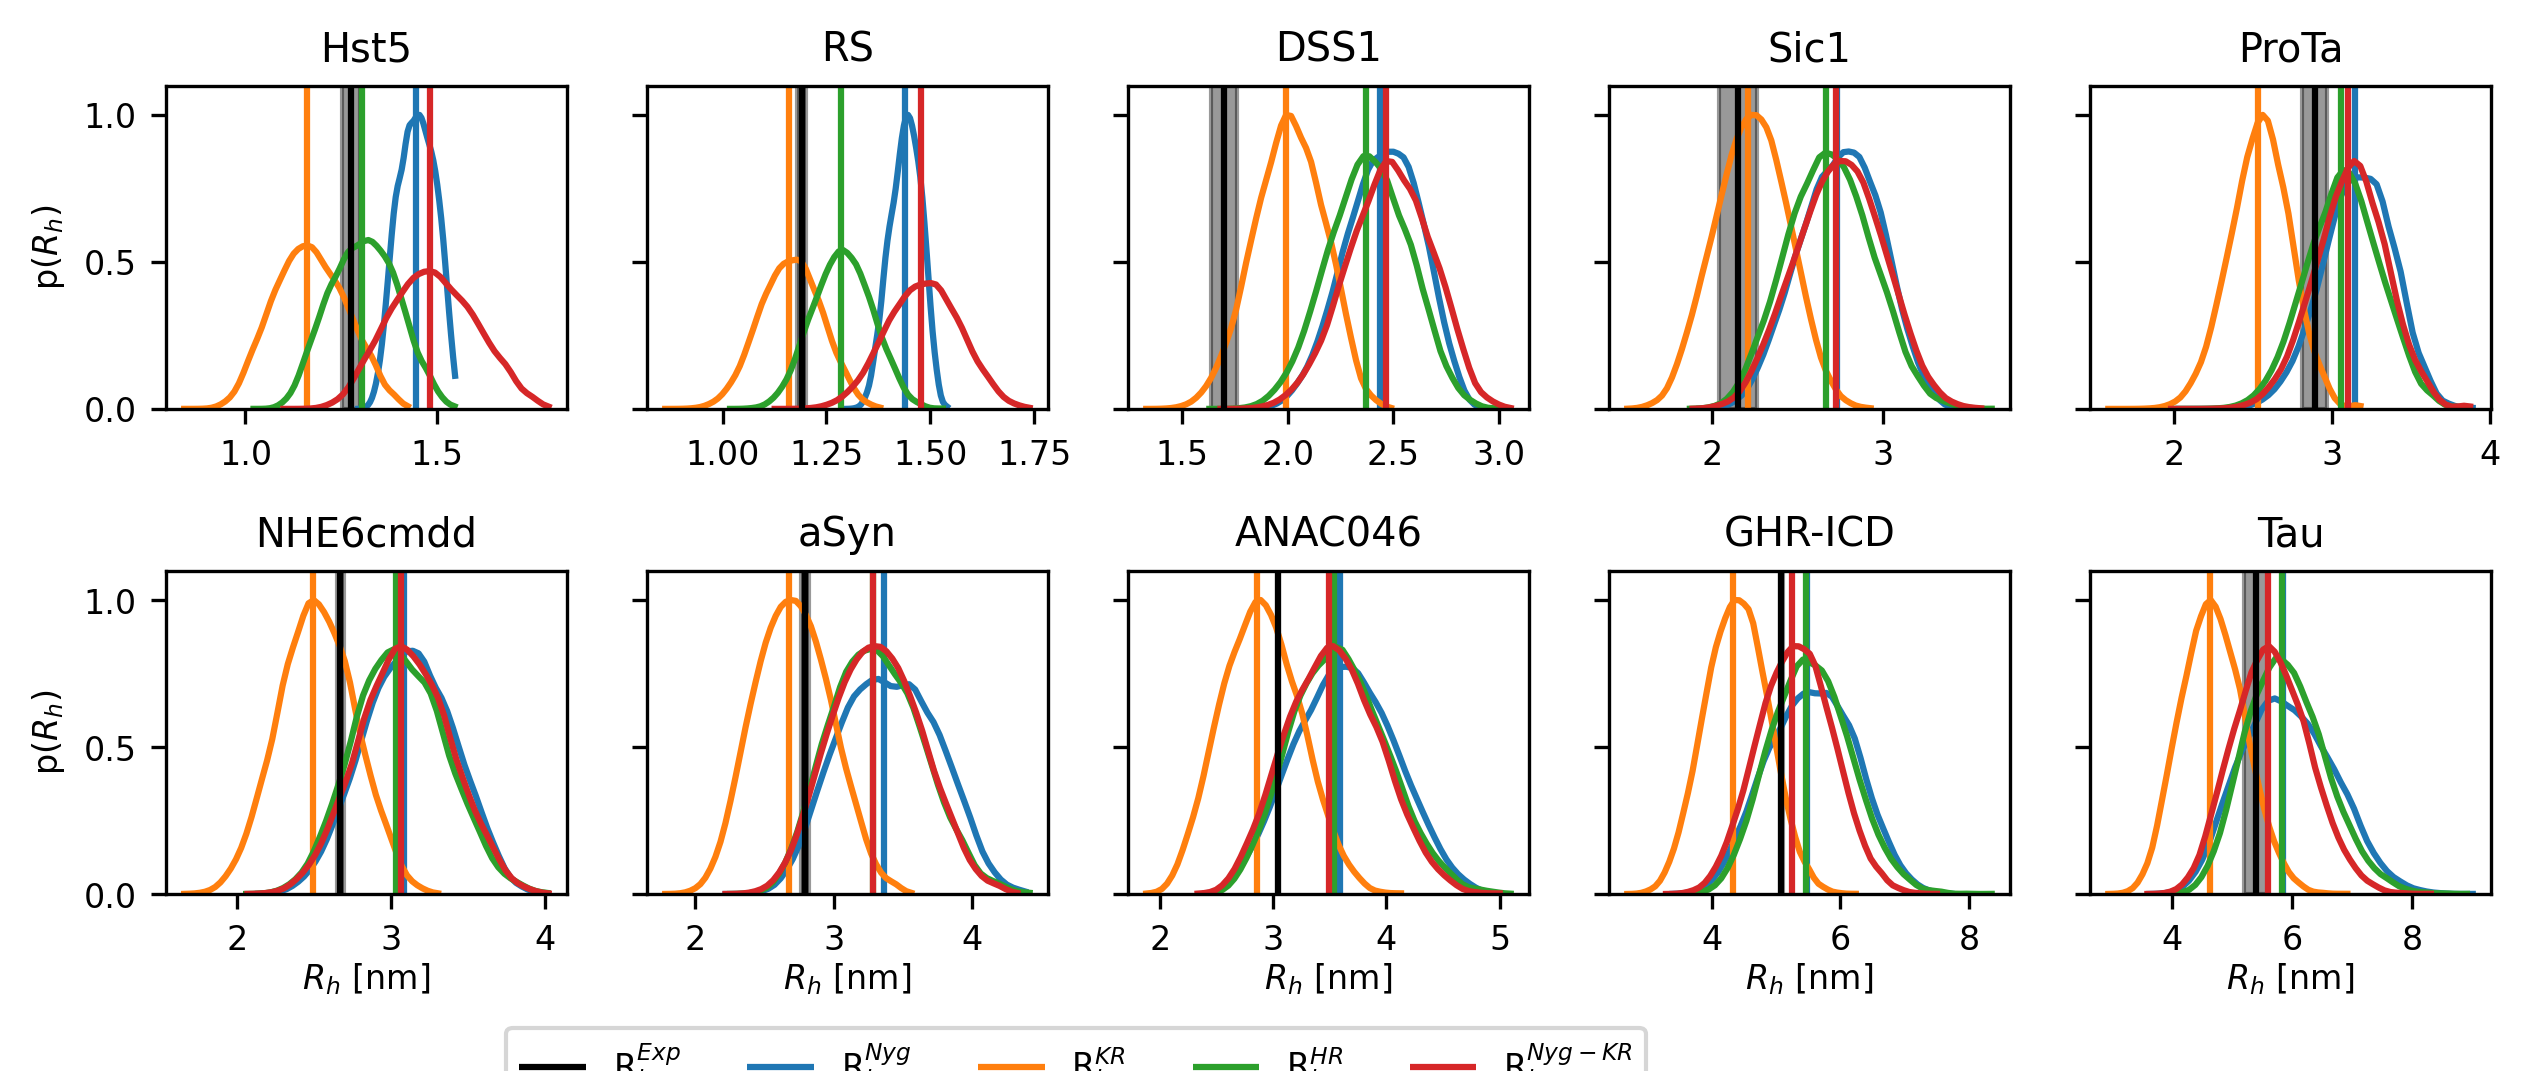

In [902]:
fig, axs = plt.subplots(2, 5, figsize=(10,3.5), gridspec_kw={'hspace':0.5, 'wspace':0.2}, sharey=True, dpi=300, facecolor='w')
for p,ax in zip(dataset.index, axs.flatten()):
    scale = np.max( [Rh_Nyg_FM[p][1].max(), Rh_Kirk_FM[p][1].max(), Rh_HR_FM[p][1].max()] )
    
    ax.plot(Rh_Nyg_FM[p][0], Rh_Nyg_FM[p][1]/scale, label=r'Nygaard ($R_g$)',color=c[0])
    l1 = ax.vlines(Rh_Nyg_FM[p][2],Rh_Nyg_FM[p][1].min()-1,Rh_Nyg_FM[p][1].max()+10,color=c[0])
    
    ax.plot(Rh_Kirk_FM[p][0], Rh_Kirk_FM[p][1]/scale, label='Kirkwood',color=c[1])
    l2 = ax.vlines(Rh_Kirk_FM[p][2],Rh_Kirk_FM[p][1].min()-1,Rh_Kirk_FM[p][1].max()+10,color=c[1])
    
    ax.plot(Rh_HR_FM[p][0], Rh_HR_FM[p][1]/scale, label='HullRad',color=c[2])
    l3 = ax.vlines(Rh_HR_FM[p][2],Rh_HR_FM[p][1].min()-1,Rh_HR_FM[p][1].max()+10,color=c[2])
    
    ax.plot(Rh_KirkNyg_FM[p][0], Rh_KirkNyg_FM[p][1]/scale, label='Nygaard (Kirkwood)',color=c[3])
    l4 = ax.vlines(Rh_KirkNyg_FM[p][2],Rh_KirkNyg_FM[p][1].min()-1,Rh_KirkNyg_FM[p][1].max()+10,color=c[3])
    
    l0 = ax.vlines(dataset.Rh[p],Rh_Nyg_FM[p][1].min()-1,Rh_Nyg_FM[p][1].max()+10,label='Exp',color='k')
    #ax.set_ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
    ax.set_ylim(0,1.1)
    ax.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
    ax.set_title(p)

axs[0,0].set_ylabel(r'p($R_h$)')
axs[1,0].set_ylabel(r'p($R_h$)')
for ax in axs.flatten()[5:]:
    ax.set_xlabel(r'$R_h$ [nm]', labelpad=1)
#axs[0,0].legend(fontsize=5)
plt.figlegend( (l0,l1,l2,l3,l4), (r'R$_h^{Exp}$' ,r'R$_h^{Nyg}$', r'R$_h^{KR}$', r'R$_h^{HR}$', r'R$_h^{Nyg-KR}$'), loc =(0.2, -0.03), ncol=5, fontsize=8 )
plt.savefig('rh_fwdmod_FM.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

In [149]:
chi2 = ([v[2] for x,v in Rh_Nyg_FM.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('Nygaard', chi2.sum())

chi2 = ([v[2] for x,v in Rh_Kirk_FM.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('Kirkwood', chi2.sum())

chi2 = ([v[2] for x,v in Rh_HR_FM.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('HullRad', chi2.sum())

chi2 = ([v[2] for x,v in Rh_KirkNyg_FM.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
print ('Kirkwood-Nygaard', chi2.sum())

Nygaard 1015.5649699572266
Kirkwood 253.75178181694832
HullRad 638.9322059587812
Kirkwood-Nygaard 979.966677577704


### Fitting correction to Kirkwood equation - M1

In [907]:
for p in dataset.index:    
    inv_rh = {}
    for p in dataset.index:
        inv_rh[p] = 1./ ( np.loadtxt(p+'/Rh_Kirk_Ca.dat') )

In [911]:
def kirk_scaling(k):
        
    av_rh = {}
    for p in dataset.index:
        av_rh[p] = 1./ np.average(inv_rh[p]+(dataset.length[p]*k), weights=weights_M1[p])
    chi2 = ([v for x,v in av_rh.items()] - dataset.Rh.values)**2 / (dataset.Rh_rel_err.values)**2
    
    return(chi2.sum())

In [914]:
resM1 = minimize(kirk_scaling, [1.], options={'disp': True})
print(resM1.x)

         Current function value: 157.313914
         Iterations: 1
         Function evaluations: 152
         Gradient evaluations: 70
[-8.90620016e-05]


In [915]:
def kde(a, w=None, k=0, l=1):
    if type(w) == 'NoneType':
        w = np.full(len(a), 1)
    a = 1/(1/a+(l*k))
    min_ = np.min(a)
    max_ = np.max(a)
    x = np.linspace( min_, max_, num = 50 )
    d = scs.gaussian_kde( a, bw_method = "silverman", weights = w ).evaluate(x)
    u = 1./np.average(1./a, weights = w)
    return x,d,u

### Leave-one-out

In [916]:
err = []
for p in dataset.index:
    dataset_tmp = dataset.drop(p, axis=0)
    
    inv_rh = {}
    for p in dataset_tmp.index:
        inv_rh[p] = 1./ ( np.loadtxt(p+'/Rh_Kirk_Ca.dat') )
        
    def kirk_scaling(k):
        av_rh = {}
        for p in dataset_tmp.index:
            av_rh[p] = 1./ np.average(inv_rh[p]+(dataset_tmp.length[p]*k), weights=weights_M1[p])
        chi2 = ([v for x,v in av_rh.items()] - dataset_tmp.Rh.values)**2 / (dataset_tmp.Rh_rel_err.values)**2
        return(chi2.sum())
    
    res = minimize(kirk_scaling, [1.], options={'disp': True})
    Rh_loo = kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat'), weights_M1[p], k=res.x, l=dataset.length[p])[2]
    err.append((Rh_KirkNew2[p][2] - Rh_loo))
    

         Current function value: 153.185259
         Iterations: 2
         Function evaluations: 132
         Gradient evaluations: 60
         Current function value: 157.303353
         Iterations: 1
         Function evaluations: 150
         Gradient evaluations: 69
         Current function value: 36.734619
         Iterations: 2
         Function evaluations: 155
         Gradient evaluations: 72
         Current function value: 157.101102
         Iterations: 2
         Function evaluations: 144
         Gradient evaluations: 66
         Current function value: 154.642583
         Iterations: 1
         Function evaluations: 140
         Gradient evaluations: 64
         Current function value: 140.277233
         Iterations: 1
         Function evaluations: 150
         Gradient evaluations: 69
         Current function value: 155.745864
         Iterations: 1
         Function evaluations: 156
         Gradient evaluations: 72
         Current function value: 149.028423
     

In [917]:
abs(np.array(err/np.array([v[2] for k,v in Rh_KirkNew2.items()]))).mean()

0.010938543919552995

In [568]:
np.average( list(np.array(err)/np.array([v[2] for k,v in Rh_KirkNew2.items()])) )

-0.0007806212393733313

In [929]:
Rh_KirkNew = {}
for p in dataset.index:
    Rh_KirkNew[p] = kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat'), weights_M1[p], k=resM1.x, l=dataset.length[p])

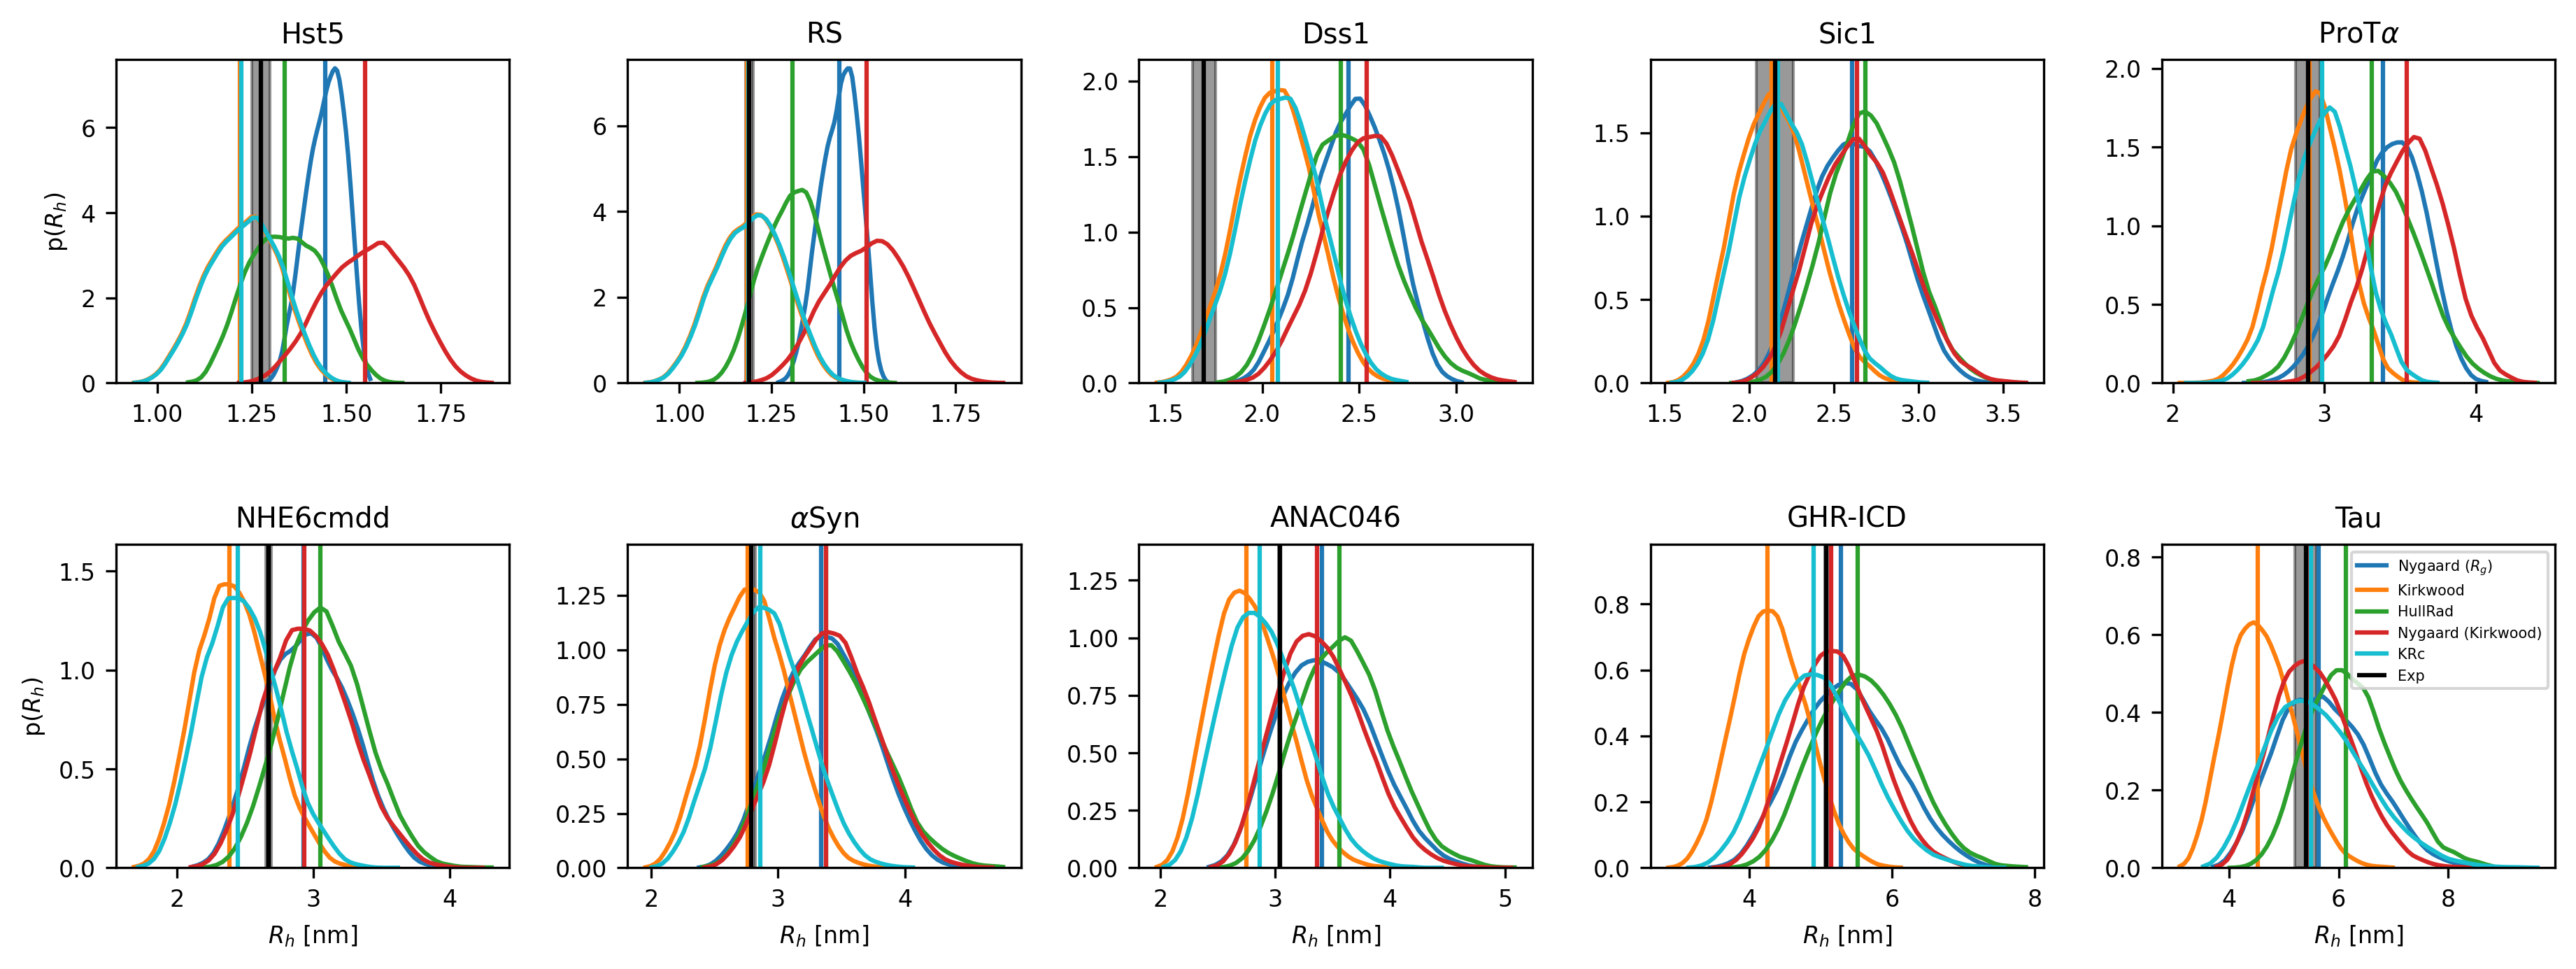

In [939]:
fig, axs = plt.subplots(2, 5, figsize=(15,5), gridspec_kw={'hspace':0.5, 'wspace':0.3}, dpi=300, facecolor='w')
for i,(p,ax) in enumerate(zip(dataset.index, axs.flatten())):

    ax.plot(Rh_Nyg[p][0], Rh_Nyg[p][1], label=r'Nygaard ($R_g$)',color=c[0])
    ax.vlines(Rh_Nyg[p][2],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,color=c[0])
    
    ax.plot(Rh_Kirk[p][0], Rh_Kirk[p][1], label='Kirkwood',color=c[1])
    ax.vlines(Rh_Kirk[p][2],Rh_Kirk[p][1].min()-1,Rh_Kirk[p][1].max()+10,color=c[1])
    
    ax.plot(Rh_HR[p][0], Rh_HR[p][1], label='HullRad',color=c[2])
    ax.vlines(Rh_HR[p][2],Rh_HR[p][1].min()-1,Rh_HR[p][1].max()+10,color=c[2])
    
    ax.plot(Rh_KirkNyg[p][0], Rh_KirkNyg[p][1], label='Nygaard (Kirkwood)',color=c[3])
    ax.vlines(Rh_KirkNyg[p][2],Rh_KirkNyg[p][1].min()-1,Rh_KirkNyg[p][1].max()+10,color=c[3])
    
    ax.plot(Rh_KirkNew[p][0], Rh_KirkNew[p][1], label='KRc',color=c[9])
    ax.vlines(Rh_KirkNew[p][2],Rh_KirkNew[p][1].min()-1,Rh_KirkNew[p][1].max()+10,color=c[9])
    
    ax.vlines(dataset_bonus.Rh[p],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,label='Exp',color='k')
    ax.set_ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
    ax.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
    ax.set_title(names_form[i])

axs[0,0].set_ylabel(r'p($R_h$)')
axs[1,0].set_ylabel(r'p($R_h$)')
for ax in axs.flatten()[5:]:
    ax.set_xlabel(r'$R_h$ [nm]')
axs[-1,-1].legend(fontsize=5)
plt.savefig('krc.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

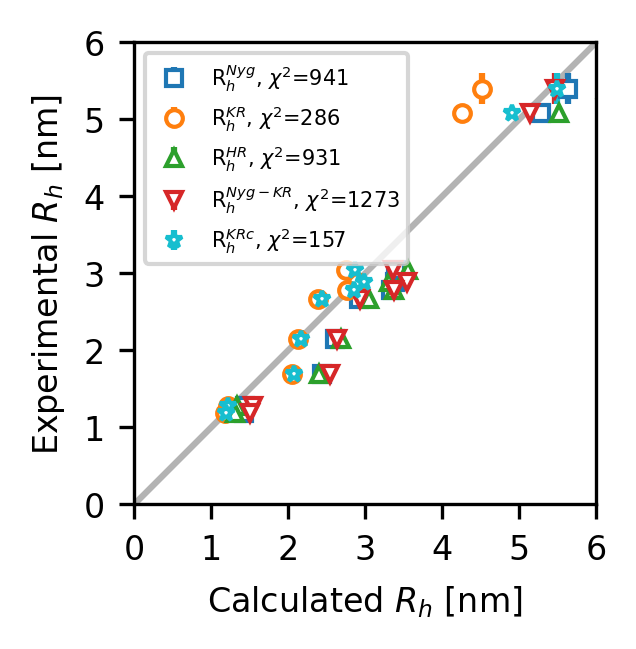

In [938]:
mpl.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(2,2), dpi=300)

ax.set_box_aspect(1)
ax.plot([0,100], [0,100], c='0.7')
ax.errorbar([v[2] for x,v in Rh_Nyg.items()], dataset.Rh, dataset.Rh_err, fmt='s', mfc='w', label=r'R$_h^{Nyg}$, $\chi^2$=941' ,ms=4,alpha=1)
ax.errorbar([v[2] for x,v in Rh_Kirk.items()], dataset.Rh, dataset.Rh_err, fmt='o', mfc='w', label=r'R$_h^{KR}$, $\chi^2$=286' ,ms=4,alpha=1)
ax.errorbar([v[2] for x,v in Rh_HR.items()], dataset.Rh, dataset.Rh_err, fmt='^', mfc='w', label=r'R$_h^{HR}$, $\chi^2$=931' ,ms=4,alpha=1)
ax.errorbar([v[2] for x,v in Rh_KirkNyg.items()], dataset.Rh, dataset.Rh_err, fmt='v', mfc='w', label=r'R$_h^{Nyg-KR}$, $\chi^2$=1273' ,ms=4,alpha=1)
ax.errorbar([v[2] for x,v in Rh_KirkNew.items()], dataset.Rh, dataset.Rh_err, fmt='*', mfc='w', label=r'R$_h^{KRc}$, $\chi^2$=157' ,ms=4,alpha=1, c=c[9])
ax.set_xlabel(r'Calculated $R_h$ [nm]')
ax.set_ylabel(r'Experimental $R_h$ [nm]')
ax.set_ylim(0,6)
ax.set_xlim(0,6)
plt.legend(fontsize=5)
ax.set_xticks(np.arange(7),np.arange(0,7))

plt.savefig('rh_full.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

### Testing KRc on FM

In [927]:
Rh_KirkNew = {}
for p in dataset.index:
    Rh_KirkNew[p] = kde( np.loadtxt('FM_old/'+p+'/Rh_Kirk_Ca.dat'), weights_FM[p], k=resM1.x, l=dataset.length[p])

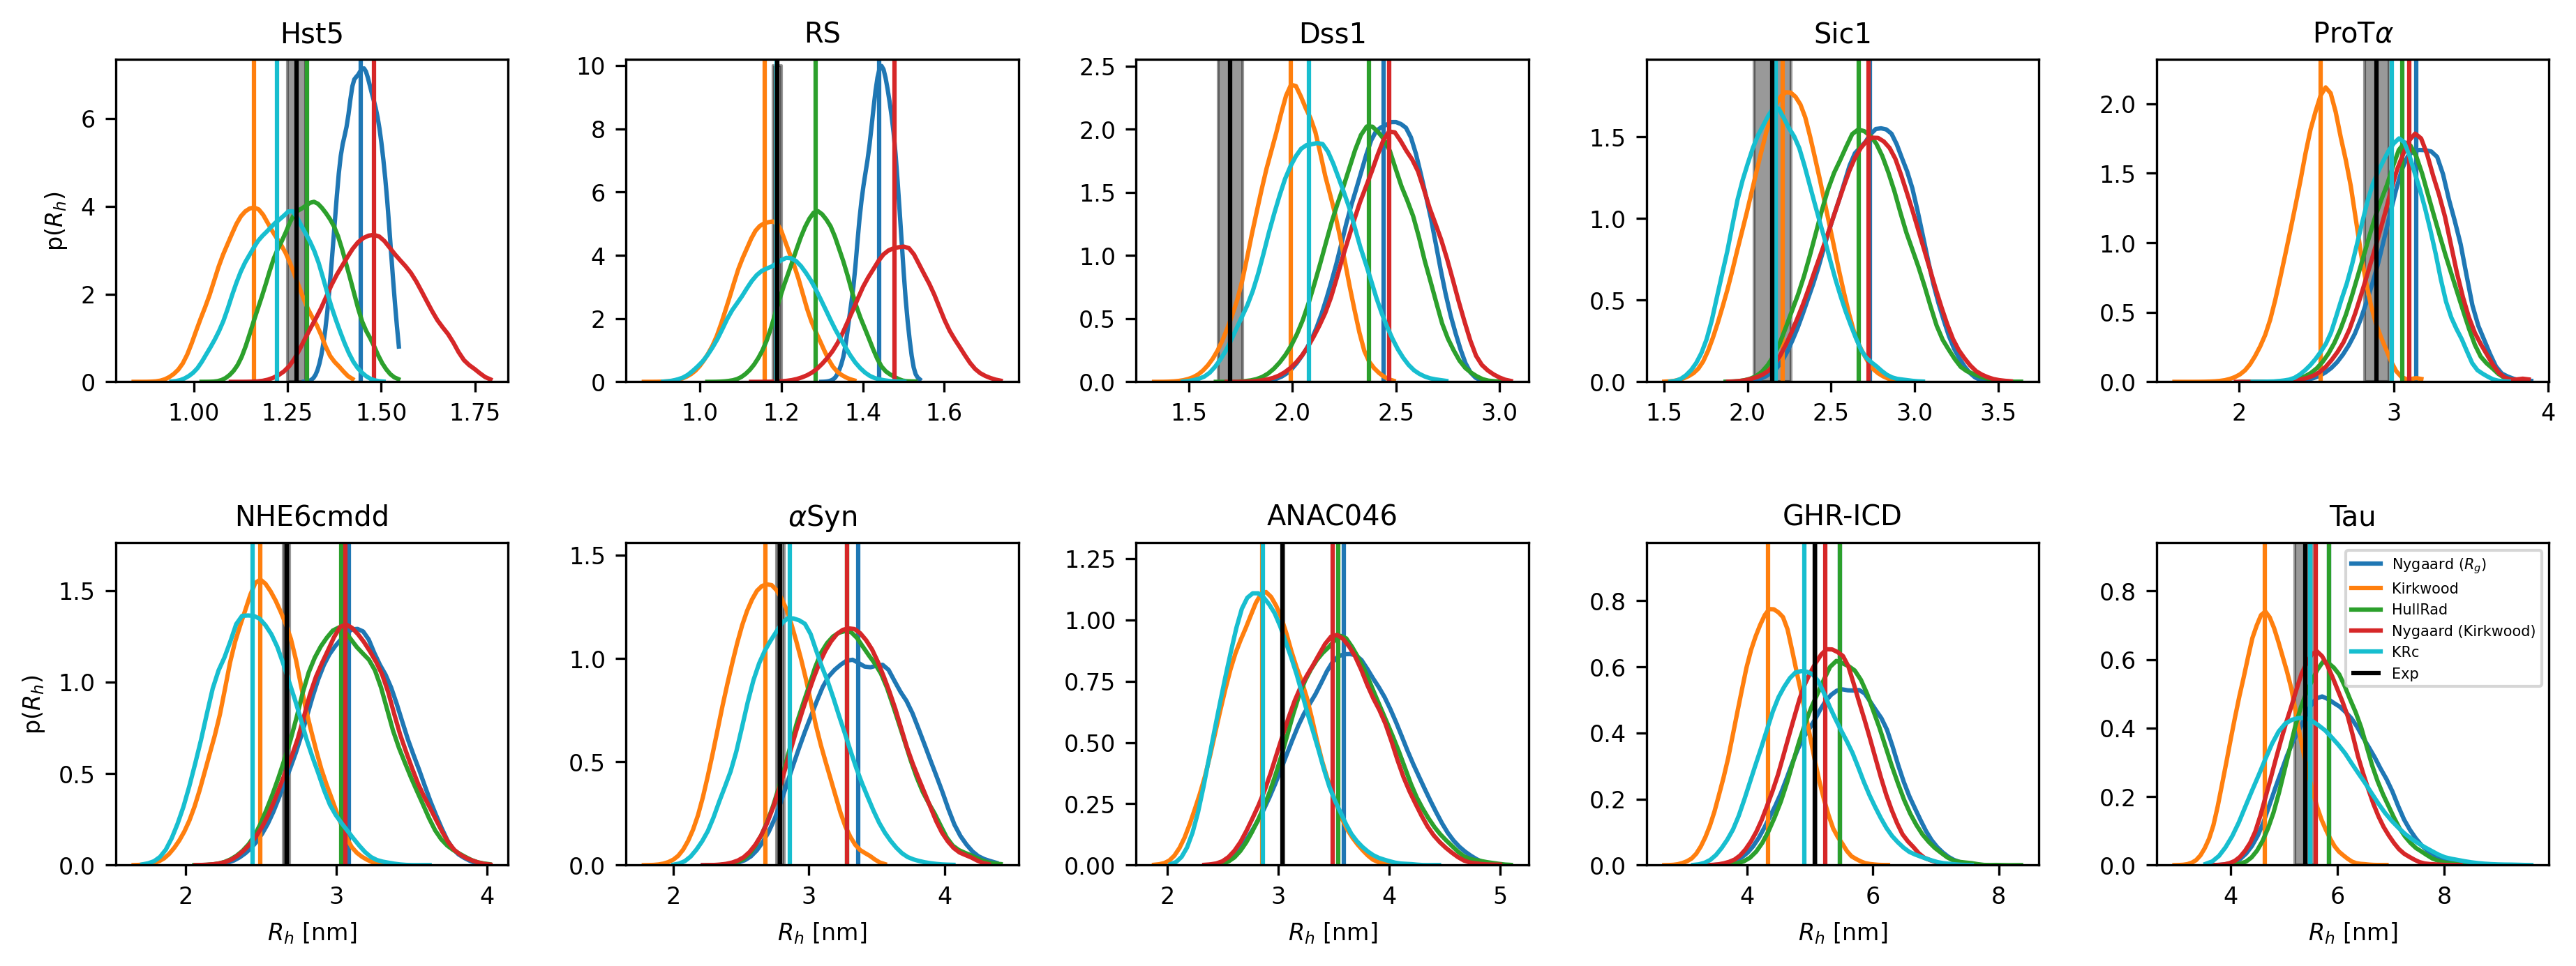

In [940]:
fig, axs = plt.subplots(2, 5, figsize=(15,5), gridspec_kw={'hspace':0.5, 'wspace':0.3}, dpi=300, facecolor='w')
for i,(p,ax) in enumerate(zip(dataset.index, axs.flatten())):

    ax.plot(Rh_Nyg_FM[p][0], Rh_Nyg_FM[p][1], label=r'Nygaard ($R_g$)',color=c[0])
    ax.vlines(Rh_Nyg_FM[p][2],Rh_Nyg_FM[p][1].min()-1,Rh_Nyg_FM[p][1].max()+10,color=c[0])
    
    ax.plot(Rh_Kirk_FM[p][0], Rh_Kirk_FM[p][1], label='Kirkwood',color=c[1])
    ax.vlines(Rh_Kirk_FM[p][2],Rh_Kirk_FM[p][1].min()-1,Rh_Kirk_FM[p][1].max()+10,color=c[1])
    
    ax.plot(Rh_HR_FM[p][0], Rh_HR_FM[p][1], label='HullRad',color=c[2])
    ax.vlines(Rh_HR_FM[p][2],Rh_HR_FM[p][1].min()-1,Rh_HR_FM[p][1].max()+10,color=c[2])
    
    ax.plot(Rh_KirkNyg_FM[p][0], Rh_KirkNyg_FM[p][1], label='Nygaard (Kirkwood)',color=c[3])
    ax.vlines(Rh_KirkNyg_FM[p][2],Rh_KirkNyg_FM[p][1].min()-1,Rh_KirkNyg_FM[p][1].max()+10,color=c[3])
    
    ax.plot(Rh_KirkNew[p][0], Rh_KirkNew[p][1], label='KRc',color=c[9])
    ax.vlines(Rh_KirkNew[p][2],Rh_KirkNew[p][1].min()-1,Rh_KirkNew[p][1].max()+10,color=c[9])
    
    ax.vlines(dataset.Rh[p],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,label='Exp',color='k')
    ax.set_ylim(0,np.max( [Rh_Nyg_FM[p][1].max(), Rh_Kirk_FM[p][1].max(), Rh_HR_FM[p][1].max()] )+0.2)
    ax.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
    ax.set_title(names_form[i])

axs[0,0].set_ylabel(r'p($R_h$)')
axs[1,0].set_ylabel(r'p($R_h$)')
for ax in axs.flatten()[5:]:
    ax.set_xlabel(r'$R_h$ [nm]')
axs[-1,-1].legend(fontsize=5)
plt.savefig('krc_fm.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

## Plot SAXS data

In [393]:
samples = ('DSS1', 'ProTa', 'NHE6cmdd', 'ANAC046')
# q-range for Guinier analysis from ATSAS autorg
qr = {
    'DSS1': exp_saxs['DSS1'][38:365],
    'ProTa': exp_saxs['ProTa'][24:237],
    'NHE6cmdd': exp_saxs['NHE6cmdd'][36:276],
    'ANAC046': exp_saxs['ANAC046'][16:100]
}

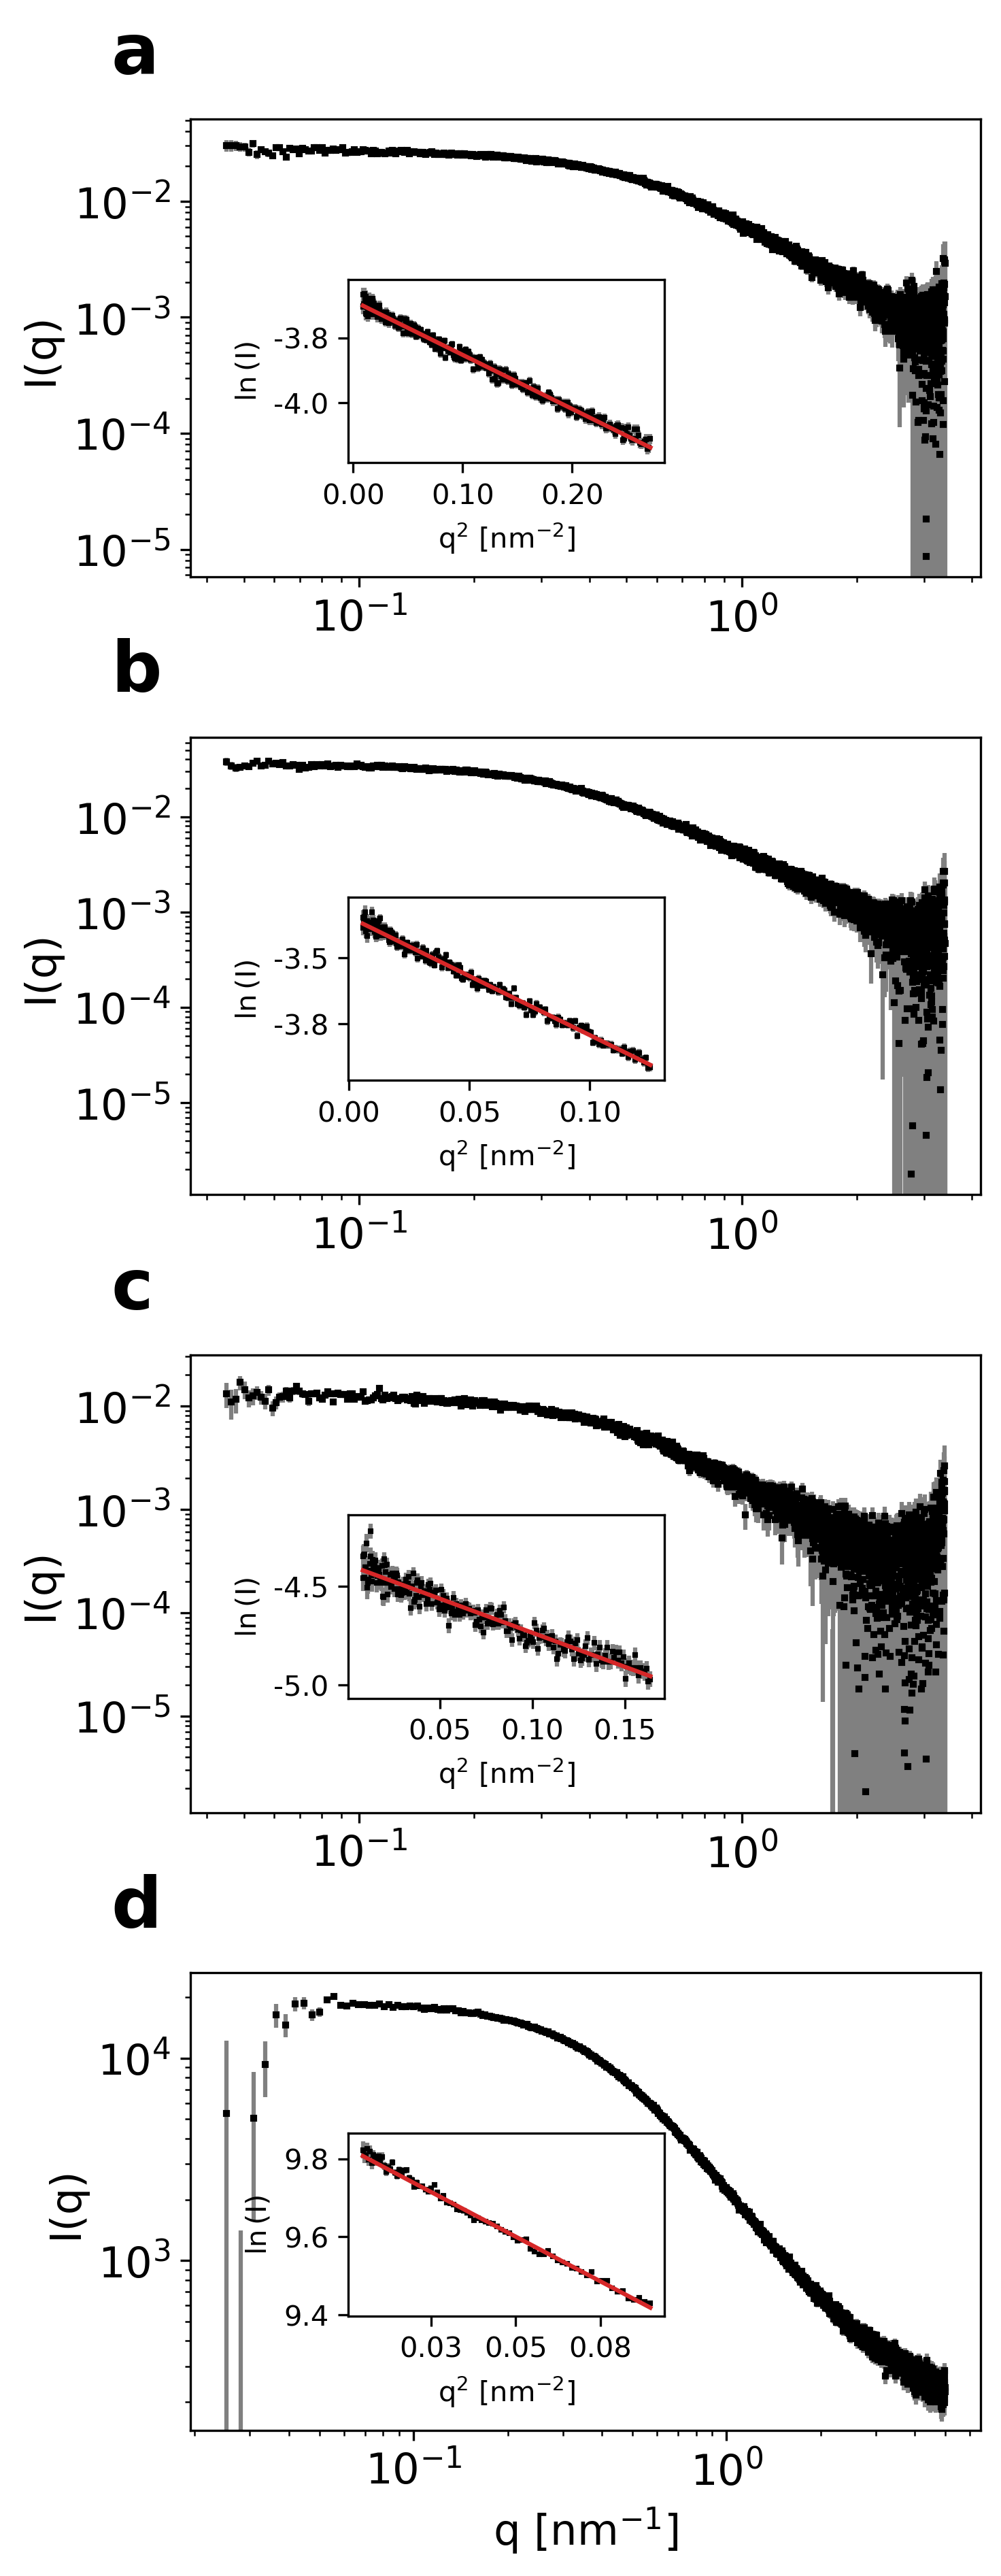

In [974]:
fig, axs = plt.subplots(4, figsize=(5,15), gridspec_kw={'hspace':0.35, 'wspace':0.25}, dpi=300, facecolor='w')
for ax,p in zip(axs.flatten(), samples):
    q = exp_saxs[p][...,0]
    i = exp_saxs[p][...,1]
    e = exp_saxs[p][...,2]
    ax.errorbar(q, i, e, label='Exp SAXS',c='k', fmt='s', ms=1.5, ecolor='0.5')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel(r'I(q)', fontsize=15)
    
    ins = ax.inset_axes([0.2,0.25,0.4,0.4])
    ins.ticklabel_format(axis='y',style='sci', scilimits=(-100,100))
    ins.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ins.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ins.errorbar(qr[p][...,0]**2, np.log(qr[p][...,1]), qr[p][...,2]/qr[p][...,1], c='k', fmt='s', ms=1, ecolor='0.5')
    a,b = np.polyfit(qr[p][...,0]**2, np.log(qr[p][...,1]), deg=1, w=1/((qr[p][...,2]/qr[p][...,1])**2))
    y = a*qr[p][...,0]**2+b
    ins.plot(qr[p][...,0]**2,y,c='tab:red',zorder=100)
    ins.set_xlabel(r'q$^2$ [nm$^{-2}$]')
    ins.set_ylabel(r'$\ln$(I)')
    

    axs[-1].set_xlabel(r'q [nm$^{-1}$]', fontsize=15)
    
for i, ax in enumerate(axs.flatten()):
    ax.text(-0.1,1.1, string.ascii_lowercase[i], fontsize=25, weight='bold', transform=ax.transAxes)
    ax.tick_params(axis='both', labelsize=15)
    
plt.savefig('saxs_exp.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

## Fig1 manuscript

In [719]:
from random import sample

In [722]:
bf_sample = [0, 0.5, 1]

In [723]:
for i in np.arange(0,20000,200):
    conf = md.load('/storage1/francesco/PROJECTS/ENSEMBLES/aSyn/FM/frame'+str(i)+'.pdb')
    #bf = np.full(len(list(conf.topology.atoms)), weights_FM['aSyn'][i])
    bf = np.full( len(list(conf.topology.atoms)), sample(bf_sample, 1)[0] )
    conf.save_pdb('/storage1/francesco/PROJECTS/RH/fig1ens/frame'+str(i)+'.pdb',bfactors=bf)

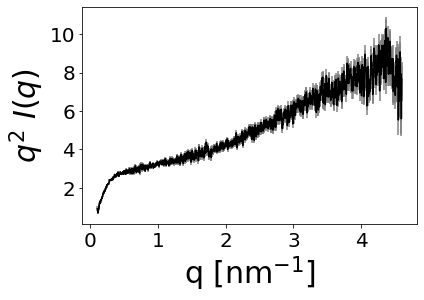

In [570]:
# Tau Kratky plot
p = 'Tau'
ndx = exp_saxs[p][...,0] < 1 

q = exp_saxs[p][...,0]
kratky_exp = (q**2)*exp_saxs[p][...,1]
kratky_err = (q**2)*exp_saxs[p][...,2]

plt.errorbar(q ,kratky_exp ,kratky_err, label='Exp SAXS', color='k', ecolor='0.5')
plt.xlabel(r'q [nm$^{-1}$]', fontsize=30)
plt.ylabel(r'$q^2$ $I(q)$', fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('fig1_saxs.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

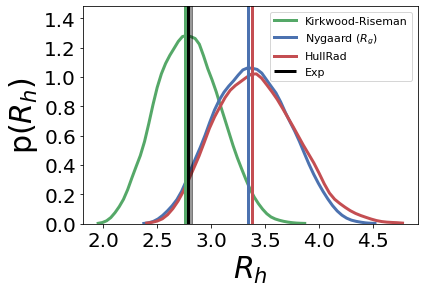

In [491]:
#Tau Kirkwood Rh
p = 'aSyn'

plt.plot(Rh_Kirk[p][0], Rh_Kirk[p][1], label='Kirkwood-Riseman',color=c[1], linewidth=3,zorder=-100)
plt.vlines(Rh_Kirk[p][2],Rh_Kirk[p][1].min()-1,Rh_Kirk[p][1].max()+10,color=c[1], linewidth=3)

plt.plot(Rh_Nyg[p][0], Rh_Nyg[p][1], label=r'Nygaard ($R_g$)',color=c[0], linewidth=3,zorder=-100)
plt.vlines(Rh_Nyg[p][2],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,color=c[0], linewidth=3)
    
plt.plot(Rh_HR[p][0], Rh_HR[p][1], label='HullRad',color=c[2], linewidth=3,zorder=-100)
plt.vlines(Rh_HR[p][2],Rh_HR[p][1].min()-1,Rh_HR[p][1].max()+10,color=c[2], linewidth=3)

plt.vlines(dataset.Rh[p],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,label='Exp',color='k', linewidth=3)
plt.ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
plt.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
plt.ylabel(r'p($R_h$)', fontsize=30)
plt.xlabel(r'$R_h$', fontsize=30)
plt.legend(fontsize=11)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('fig1_kirk.pdf', dpi=300, edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

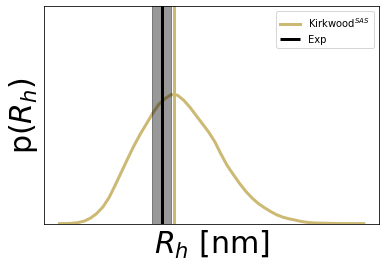

In [484]:
#Tau Kirkwood* Rh

plt.plot(Rh_KirkNew[p][0], Rh_KirkNew[p][1], label=r'Kirkwood$^{SAS}}$',color=c[4], linewidth=3,zorder=-100)
plt.vlines(Rh_KirkNew[p][2],Rh_KirkNew[p][1].min()-1,Rh_KirkNew[p][1].max()+10,color=c[4], linewidth=3)
plt.vlines(dataset.Rh[p],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,label='Exp',color='k', linewidth=3)
plt.ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
plt.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
plt.ylabel(r'p($R_h$)', fontsize=30)
plt.xlabel(r'$R_h$ [nm]', fontsize=30)
plt.legend()
plt.xticks(ticks=[])
plt.yticks(ticks=[])

plt.savefig('fig1_kirk_star.pdf', dpi=300, edgecolor='w', orientation='portrait')
plt.show()

### Calculate PFG NMR profile from calculated Rh

In [477]:
from scipy.optimize import curve_fit

In [478]:
def Stejskal_Tanner(G, D, I0):
    I = I0*np.exp( -(G*gamma*delta)**2 *(dt-(delta/3))*D )
    return I

In [479]:
gamma = 26752
dt = 0.200
delta = 0.003

In [480]:
G ={
    'aSyn': np.array([0.963,4.045,7.126,10.208,13.289,16.371,19.453,22.534,25.616,28.697,31.779,34.861,37.942,41.024,44.105,47.187]),
    'DSS1': np.array([1.034,2.636,4.237,5.839,7.441,9.042,10.644,12.245,13.847,15.448,17.05,18.651,20.253,21.854,23.456,25.058,26.659,28.261,29.862,31.464,33.065,34.667,36.268,37.87,39.471,41.073,42.675,44.276,45.878,47.479,49.081,50.682]), 
    'GHR-ICD': np.array([1.034,2.636,4.237,5.839,7.441,9.042,10.644,12.245,13.847,15.448,17.05,18.651,20.253,21.854,23.456,25.058,26.659,28.261,29.862,31.464,33.065,34.667,36.268,37.87,39.471,41.073,42.675,44.276,45.878,47.479,49.081,50.682]),
    'NHE6cmdd': np.array([2.541,4.066,5.591,7.115,8.64,10.165,11.69,13.214,14.739,16.264,17.789,19.313,20.838,22.363,23.888,25.412,26.937,28.462,29.987,31.511,33.036,34.561,36.086,37.61,39.135,40.66,42.185,43.709,45.234,46.759,48.284,49.808]),
    'ANAC046': np.array([2.407,3.805,5.203,6.601,7.999,9.397,10.795,12.193,13.591,14.989,16.387,17.784,19.182,20.58,21.978,23.376,24.774,26.172,27.57,28.968,30.366,31.763,33.161,34.559,35.957,37.355,38.753,40.151,41.549,42.947,44.345,45.742])
    
}
I_exp = {
    'aSyn': np.array([15485266,15773410,15229786,14478059,13266520,11998732,10662664,9460325,8374958,7217384,6054632,5067632,4090203,3362176,2673208,2055151]),
    'DSS1': np.array([37832587,35455488,35012631,36573375,35249421,34324558,32848729,31293218,29735641,27979615,26422721,24615491,22942104,21286278,19419122,17787872,16184389,14636578,13062690,11643456,10225249,9119071,7937476,6955608,6022688,5148014,4294117,3695463,3113277,2675152,2273368,1890241]),
    'GHR-ICD': np.array([2657880290,2649679346,2621386065,2580174595,2527466423,2464829491,2391779737,2311497967,2219988332,2123731998,2021780791,1914600698,1808887696,1695485357,1584025836,1473229963,1361390894,1254453367,1151014157,1051131324,954070868,863560116,776331202,695979453,622439550,552844528,488338566,430531246,373911173,326378402,283671314,246048160]),
    'NHE6cmdd': np.array([189673089,190719084,191039607,191696124,191746521,189326340,188363525,185963654,182791344,179601143,175895800,172018057,168094745,163026936,158443558,153552069,148653244,143483370,138234661,132593947,127452554,121870895,116764692,111706713,105868703,100488831,95285914,90344539,85392329,80677400,75903939,71329065]),
    'ANAC046': np.array([1172931954,1163885576,1148561250,1129484395,1106199940,1078542397,1046812580,1012427828,975346103,935705918,894137388,851134693,806087369,761098874,715933167,670114206,625116185,580346257,537183787,495441814,454894006,415771356,379199167,344354844,311073767,279892643,251045573,225278392,201335366,178255369,157451162,138220100])
    
}
I_DIOX = {
    'aSyn': np.array([2299859099,1895194598,1229809021,630187265,255736074,82511497,21089231,4225036,568381,115534,101068,-112,161092,107924,97165,93281]),
    'DSS1': np.array([2570254572,2456465379,2253455760,1976905423,1659179043,1334747381,1030946922,763505401,542596439,370385757,242651321,152627692,92161360,53521219,29833699,15992875,8173840,3989355,1833507,752207,244142,-17383,-88945,-139504,-144797,-149972,-102324,-164739,-144397,-152761,-144912,-143058]),
    'GHR-ICD': np.array([3074192032,2687696634,2094015310,1450774054,899113617,501090653,254785590,122150601,58578983,31731902,21412760,16963645,15380873,14206822,13070587,11964036,11019466,9869343,8947559,8070727,7510034,6432460,5967473,5164268,4815424,3994737,3434195,3146770,2153713,1851541,1329802,1112463]),
    'NHE6cmdd': np.array([1695847669,1613141097,1496920302,1357058064,1201736713,1037902316,876026174,722504338,581684970,458531896,353177976,266006671,195919622,141572665,99941333,69064246,46852485,31488952,20713042,13439199,8457779,5397121,3592429,2430280,1693820,999380,764906,653125,453563,305422,449028,262261]),
    'ANAC046': np.array([2893867470,2543013503,2104997289,1643788838,1211913722,845251334,559572260,352679794,213322292,124977350,72946585,43656702,27775090,19593842,15298874,12965865,11436147,10212647,9594086,8728759,7859863,7257331,6506761,5859863,5361654,4768258,3915039,3514684,3301326,2867403,2592893,2257151])
}

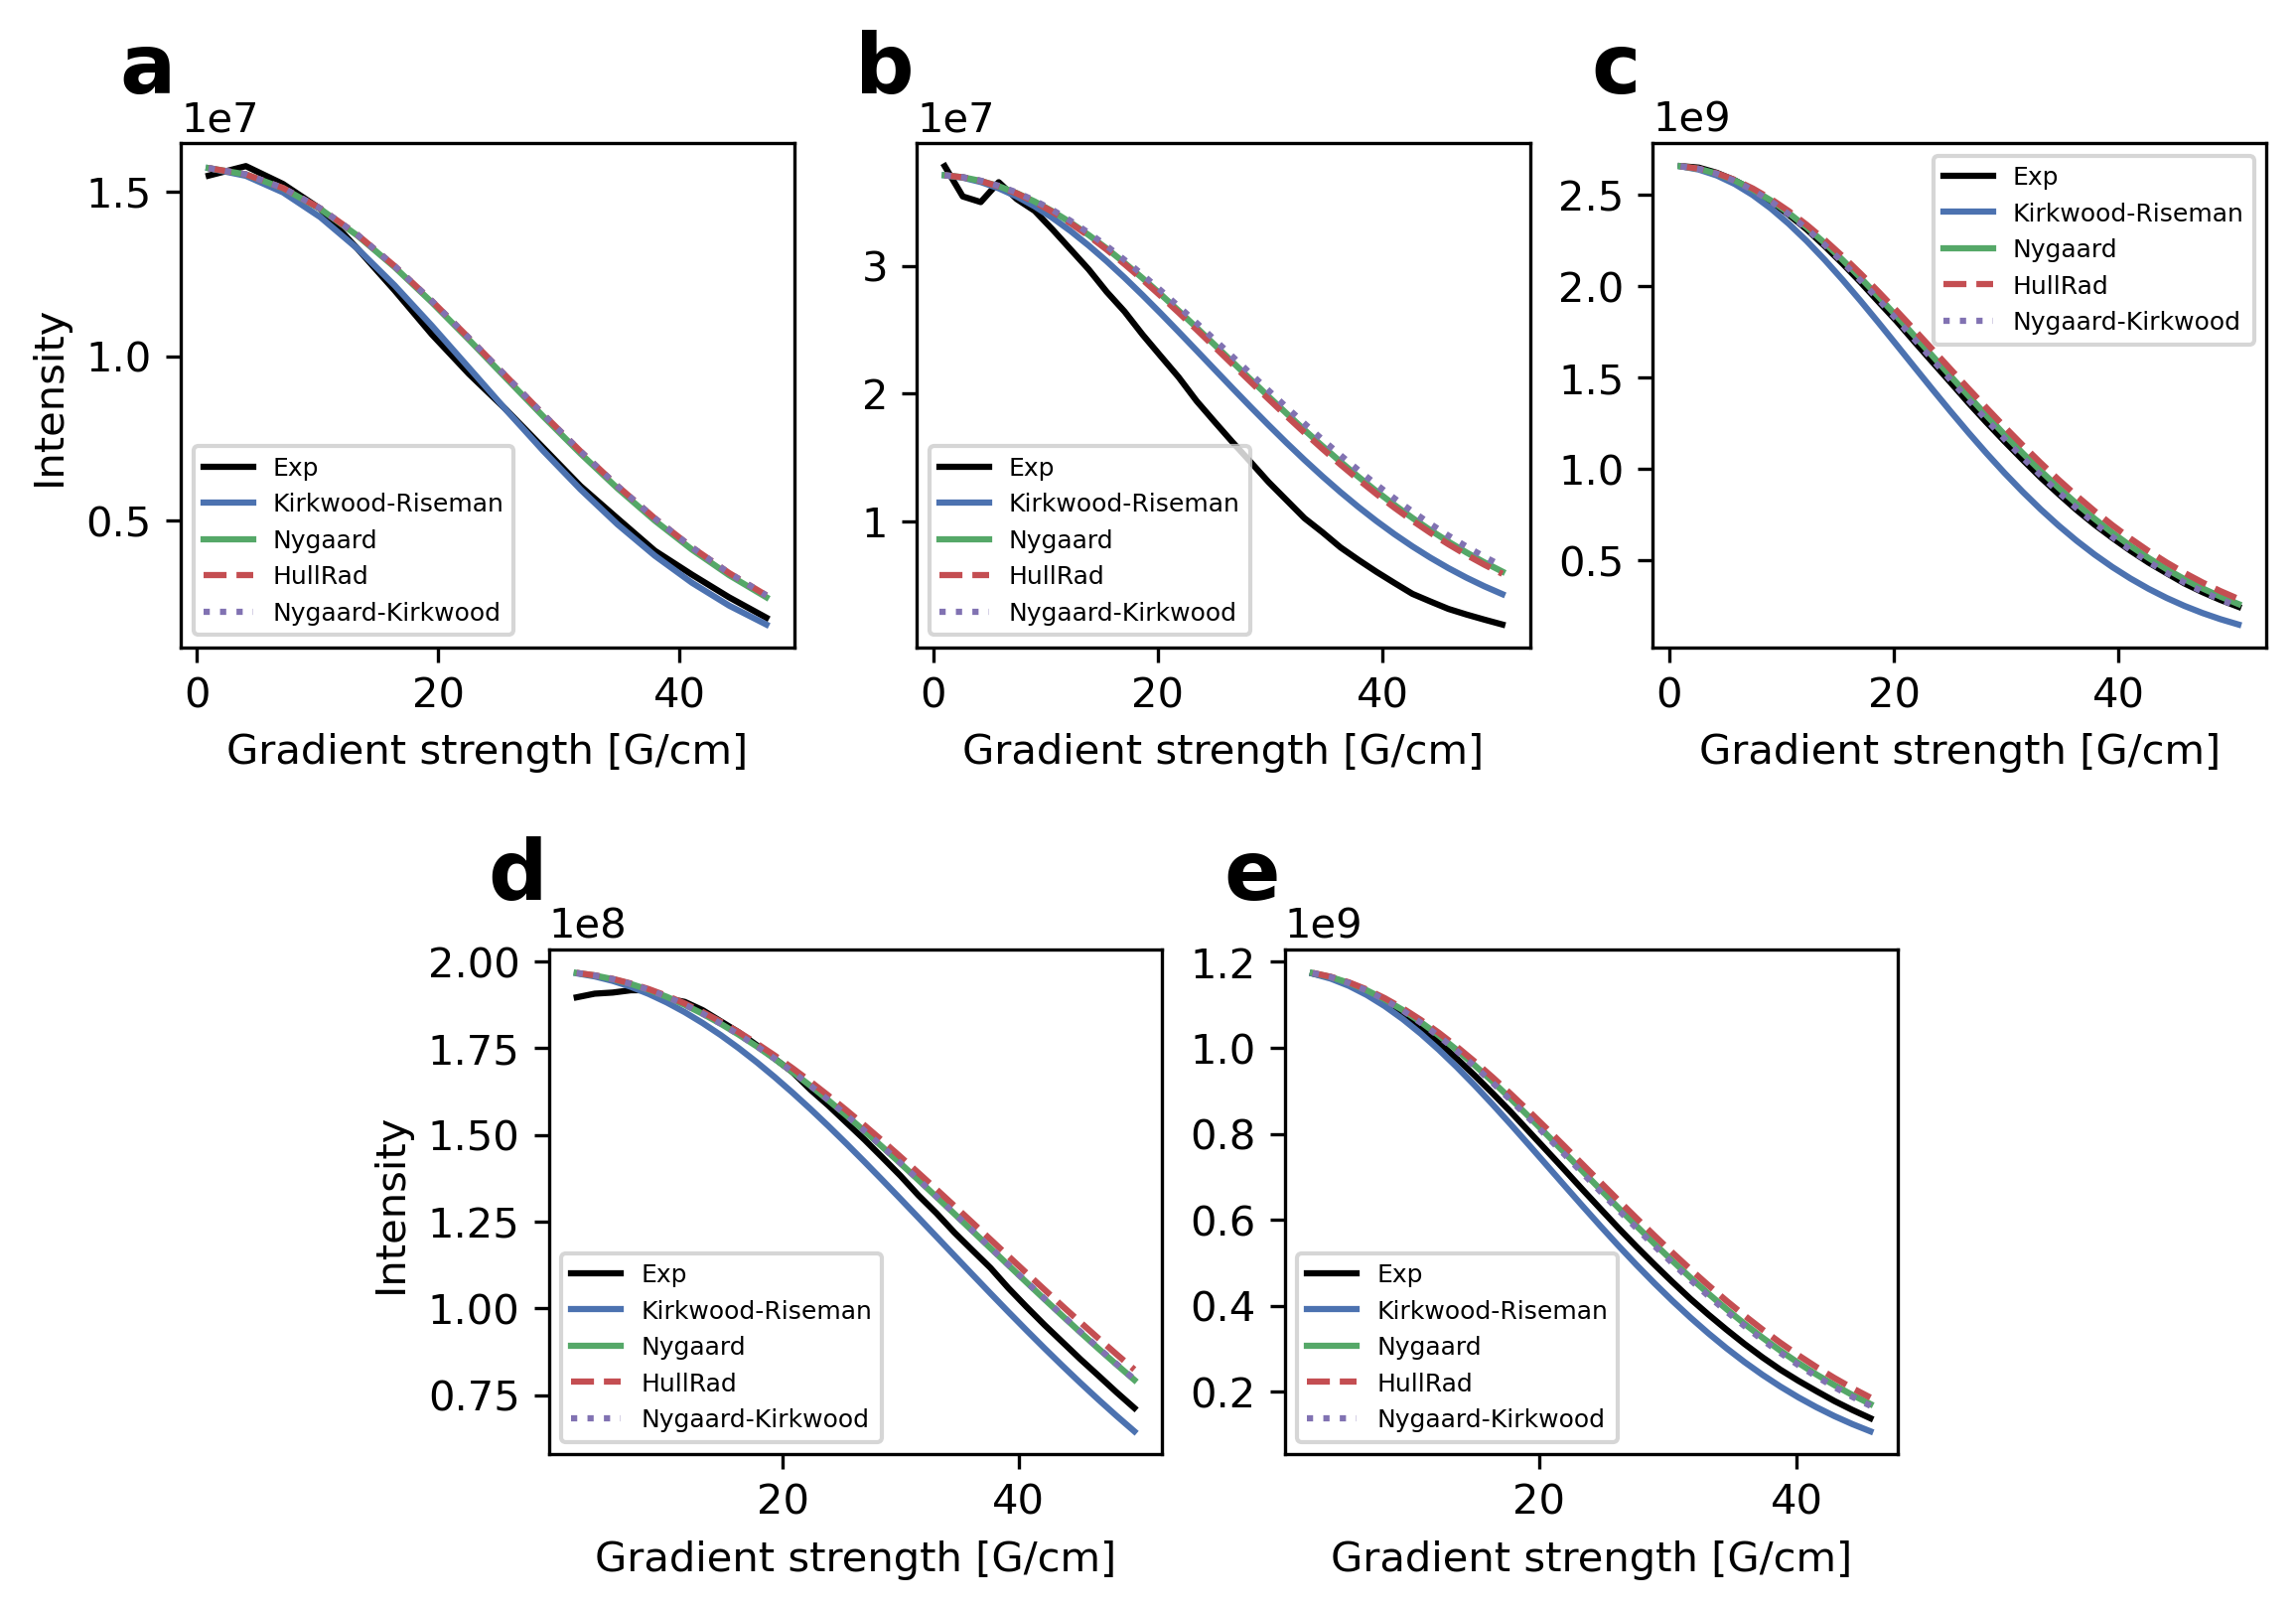

In [929]:
fig = plt.subplots(figsize=(5,4), facecolor='w', dpi=300,sharex=True)
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
axs = [ax1,ax2,ax3,ax4,ax5]
for p,ax in zip(G.keys(), axs):
    poptD, _ = curve_fit(Stejskal_Tanner, G[p], I_DIOX[p], p0=[0.000001, I_DIOX[p][0]])
    poptP, _ = curve_fit(Stejskal_Tanner, G[p], I_exp[p], p0=[0.000001, I_exp[p][0]])
    
    Dp_Kirk = 0.212*poptD[0]/Rh_Kirk[p][2]
    Dp_HR = 0.212*poptD[0]/Rh_HR[p][2]
    Dp_Nyg = 0.212*poptD[0]/Rh_Nyg[p][2]
    Dp_KirkNyg = 0.212*poptD[0]/Rh_KirkNyg[p][2]
    
    ax.plot(G[p], I_exp[p],c='k',label='Exp')
    ax.plot(G[p], Stejskal_Tanner(G[p], Dp_Kirk, poptP[1]),label='Kirkwood-Riseman')
    ax.plot(G[p], Stejskal_Tanner(G[p], Dp_Nyg, poptP[1]), label='Nygaard')
    ax.plot(G[p], Stejskal_Tanner(G[p], Dp_HR, poptP[1]), label='HullRad', ls='dashed')
    ax.plot(G[p], Stejskal_Tanner(G[p], Dp_KirkNyg, poptP[1]), label='Nygaard-Kirkwood', ls='dotted')
    ax.legend(fontsize=6)
    ax.set_xlabel(r'Gradient strength [G/cm]')
    
ax1.set_ylabel(r'Intensity')
ax4.set_ylabel(r'Intensity')
    
for i, ax in enumerate(axs):
    ax.text(-0.1,1.1, string.ascii_lowercase[i], fontsize=20, weight='bold', transform=ax.transAxes)
    #ax.tick_params(axis='both', labelsize=15)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.5, 
                    top=1.2, 
                    wspace=0.5, 
                    hspace=0.6)
plt.savefig('diff_prof.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

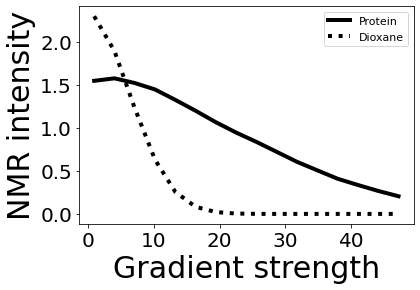

In [607]:
plt.plot(G['aSyn'], I_exp['aSyn']*100/1e9, label=r'Protein', linewidth=4, c ='k')
plt.plot(G['aSyn'], I_DIOX['aSyn']/1e9, label=r'Dioxane', linewidth=4, c='k', ls='dotted')

plt.ylabel('NMR intensity', fontsize=30)
plt.xlabel('Gradient strength', fontsize=30)
plt.legend(fontsize=11)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('fig1_pfgnmr.pdf', dpi=300, edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()